# 2. Data Pre-processing

## Import necessary packages

In [1]:
# Install necessary packages, if not present
# !pip install tensorflow
# !pip install sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats 
import datetime as dt
import datetime
import time

# % matplotlib inline

# feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# model training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import cross_validate
from sklearn import linear_model

# classifiers
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.linear_model import LogisticRegression # logistic regression
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from numpy import where

## Read CSV File

In [2]:
df = pd.read_csv('data/loan.csv',low_memory=True)
df.head()

/Users/chihongtao/anaconda/envs/notebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## Check column info and NULL values

In [3]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 145 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          0 non-null        float64
 1   member_id                                   0 non-null        float64
 2   loan_amnt                                   2260668 non-null  int64  
 3   funded_amnt                                 2260668 non-null  int64  
 4   funded_amnt_inv                             2260668 non-null  float64
 5   term                                        2260668 non-null  object 
 6   int_rate                                    2260668 non-null  float64
 7   installment                                 2260668 non-null  float64
 8   grade                                       2260668 non-null  object 
 9   sub_grade                                   2260668 non-

## Add a few useful columns

In [4]:
# Extract the year & month from issue_d
df['issue_y'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.year)
df['issue_m'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce').apply(lambda x: x.month)

In [5]:
# Inspect loan status
df['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [6]:
# Remove loans under "Current" status
df = df[df['loan_status']!='Current']

# We can categorise the loan as good / bad loan. 
bad_loan_statuses = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", \
                     "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
df['loan_condition'] = df['loan_status'].apply(lambda x: 'bad' if x in bad_loan_statuses else 'good')

In [7]:
# Add Region column
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'

df['region'] = df['addr_state'].apply(finding_regions)

## Split the data into Train, Test set
First, we split the dataframe into x - variables, y - labels (whether the loan is a good / bad loan). Here, we classify these loan status as bad loans, for which either the borrower is not able to pay back, or is late in payment. For this, we will use the newly created column: loan_condition, which will be the y label in our dataset. Later during training, we also need to __drop loan_status column__ from the x variables, because of its correlation with the label column.

In [8]:
y = df['loan_condition']
x = df.drop(columns=['loan_condition'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=0)

df_train = x_train.merge(y_train, left_index=True, right_index=True)
df_test = x_test.merge(y_test, left_index=True, right_index=True)
print (df_train.info(verbose=True, null_counts=True))
print (df_test.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1005729 entries, 1832470 to 868271
Data columns (total 149 columns):
 #   Column                                      Non-Null Count    Dtype  
---  ------                                      --------------    -----  
 0   id                                          0 non-null        float64
 1   member_id                                   0 non-null        float64
 2   loan_amnt                                   1005729 non-null  int64  
 3   funded_amnt                                 1005729 non-null  int64  
 4   funded_amnt_inv                             1005729 non-null  float64
 5   term                                        1005729 non-null  object 
 6   int_rate                                    1005729 non-null  float64
 7   installment                                 1005729 non-null  float64
 8   grade                                       1005729 non-null  object 
 9   sub_grade                                   1005729

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335244 entries, 733217 to 698290
Data columns (total 149 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          0 non-null       float64
 1   member_id                                   0 non-null       float64
 2   loan_amnt                                   335244 non-null  int64  
 3   funded_amnt                                 335244 non-null  int64  
 4   funded_amnt_inv                             335244 non-null  float64
 5   term                                        335244 non-null  object 
 6   int_rate                                    335244 non-null  float64
 7   installment                                 335244 non-null  float64
 8   grade                                       335244 non-null  object 
 9   sub_grade                                   335244 non-null  obj

## Cleaning up columns / rows from training & test data
From above information, we can see for quite a few columns, there are significant number of rows with null values. This is common for both the training and test dataset. Next, we will attempt to remove some of the less useful columns.

More specifically, we will check how many columns has more than 30% of null values, and remove those. 

(1340973, 149)
(58,)


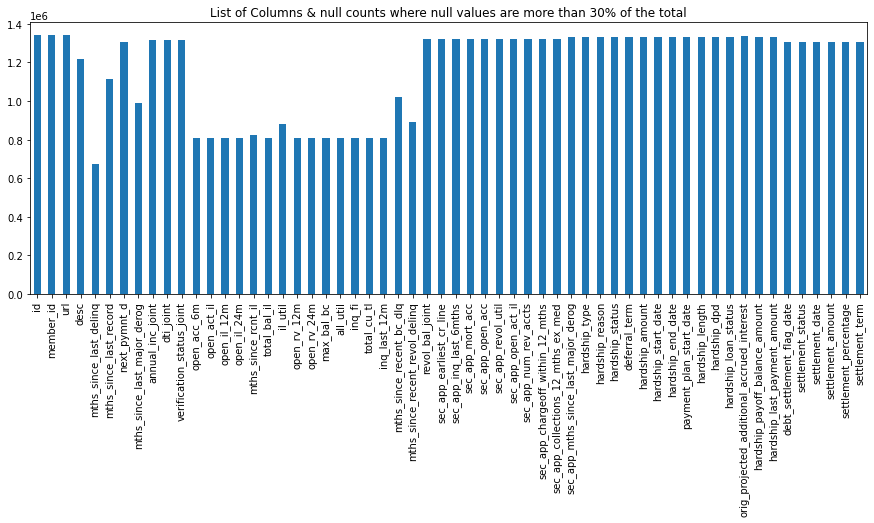

In [9]:
print (df.shape)
null_col = df.isnull().sum()
null_col = null_col[null_col.values >(0.3*len(df))]
print (null_col.shape)
plt.figure(figsize=(15,5))
null_col.plot(kind='bar')
plt.title('List of Columns & null counts where null values are more than 30% of the total')
plt.show()

From above plot, we can see that out of the 151 columns from the original dataset, 58 columns have more than 30% of the rows with nul values. We will hence drop these 58 columns in both the training and test dataset, since too many null values will not help much in our training and prediction.

In [10]:
df_train.drop(columns=list(null_col.index), inplace=True)
print (df_train.shape)
df_test.drop(columns=list(null_col.index), inplace=True)
print (df_test.shape)

(1005729, 91)
(335244, 91)


Similarly, we check if there are any rows that have more than 30% null values populated. We will go ahead and remove those rows

In [11]:
# Drop rows with too many null values, for training data
df_transposed = df_train.transpose()
null_rows = df_transposed.isnull().sum()
null_rows = null_rows[null_rows.values >(0.3*len(df_transposed))]
print (null_rows.shape)
df_train.drop(axis=0, labels=list(null_rows.index), inplace=True)
print (df_train.shape)

# Drop rows with too many null values, for test data
df_transposed = df_test.transpose()
null_rows = df_transposed.isnull().sum()
null_rows = null_rows[null_rows.values >(0.3*len(df_transposed))]
print (null_rows.shape)
df_test.drop(axis=0, labels=list(null_rows.index), inplace=True)
print (df_test.shape)

(37554,)
(968175, 91)
(12679,)
(322565, 91)


After dropping null columns & rows, we check for columns where there is only one unique values. Those are not very useful in prediction, and we will remove them as well. We will do this for both the training and test dataset

In [12]:
unique = df_train.nunique()
df_train.drop(axis=1, labels=list(unique[unique==1].index), inplace=True)
print (unique[unique==1])
print (df_train.shape)

unique = df_test.nunique()
df_test.drop(axis=1, labels=list(unique[unique==1].index), inplace=True)
print (unique[unique==1])
print (df_test.shape)

policy_code    1
dtype: int64
(968175, 90)
policy_code    1
dtype: int64
(322565, 90)


Next, we handle a few specific columns. This will be done for both the training & test dataset.
* For employment length column, we will fill the null values with 0.
* We will also drop the zip code column, as geographical information is already contained in state (addr_state) field.

In [13]:
# print (df_unique.emp_length.value_counts(dropna=False))
df_train.emp_length.fillna(0, inplace=True)
df_test.emp_length.fillna(0,inplace=True)
df_train.drop(columns='zip_code',inplace=True)
df_test.drop(columns='zip_code',inplace=True)
print (df_train.shape)
print (df_test.shape)

(968175, 89)
(322565, 89)


Next, we add one useful column: loan_to_income_ratio, which will be useful in prediction based on domain understanding.
* In previous analysis, we have also added a few columns, such as issue_y, issue_m, region, 

In [14]:
# Calculate the ratio of loan to annual income, as an indication of the risk for the borrower
df_train['loan_to_income_ratio'] = df_train['loan_amnt'] / df_train['annual_inc']
df_test['loan_to_income_ratio'] = df_test['loan_amnt'] / df_test['annual_inc']

print (df_train.shape)
print (df_test.shape)
df_train.info(verbose=True, null_counts=True)

(968175, 90)
(322565, 90)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 968175 entries, 1832470 to 868271
Data columns (total 90 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   968175 non-null  int64  
 1   funded_amnt                 968175 non-null  int64  
 2   funded_amnt_inv             968175 non-null  float64
 3   term                        968175 non-null  object 
 4   int_rate                    968175 non-null  float64
 5   installment                 968175 non-null  float64
 6   grade                       968175 non-null  object 
 7   sub_grade                   968175 non-null  object 
 8   emp_title                   905989 non-null  object 
 9   emp_length                  968175 non-null  object 
 10  home_ownership              968175 non-null  object 
 11  annual_inc                  968175 non-null  float64
 12  verification_status         968175 non-n

## Univariate Analysis - continuous variable

Then, we will perform some __univariate analysis__ on both continuous and categorical variables, in order to remove outliers to further trim down on the number of rows. 

First, we examine of some of the key continuous variables, namely Loan Amount, Interest Rate, Annual Income

(962557, 90)
(320778, 90)


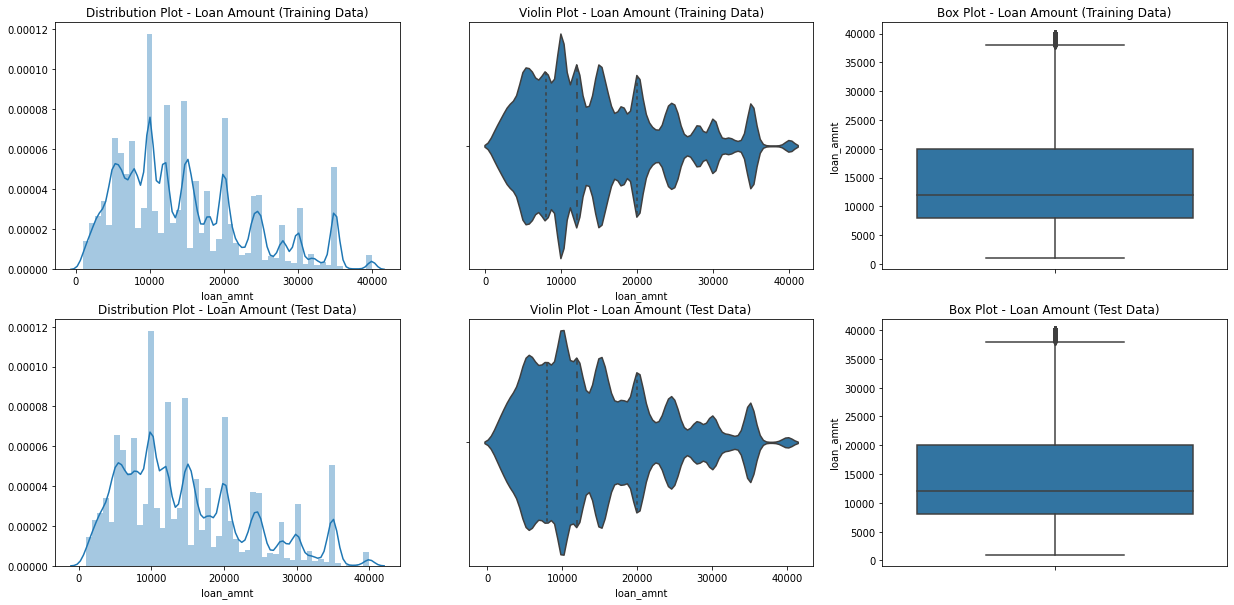

In [15]:
# Plotting for Loan Amount, in training dataset
fig, ax = plt.subplots(2,3,figsize=(21,10))
ax[0][0].set_title("Distribution Plot - Loan Amount (Training Data)")
sns.distplot(df_train['loan_amnt'],ax=ax[0][0])
ax[0][1].set_title("Violin Plot - Loan Amount (Training Data)")
sns.violinplot(data=df_train, x='loan_amnt',ax=ax[0][1], inner="quartile")
ax[0][2].set_title("Box Plot - Loan Amount (Training Data)")
sns.boxplot(data=df_train, x='loan_amnt',ax=ax[0][2],orient='v')

# Plottting for Loan Amount, in test dataset
ax[1][0].set_title("Distribution Plot - Loan Amount (Test Data)")
sns.distplot(df_test['loan_amnt'],ax=ax[1][0])
ax[1][1].set_title("Violin Plot - Loan Amount (Test Data)")
sns.violinplot(data=df_test, x='loan_amnt',ax=ax[1][1], inner="quartile")
ax[1][2].set_title("Box Plot - Loan Amount (Test Data)")
sns.boxplot(data=df_test, x='loan_amnt',ax=ax[1][2],orient='v')

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_train_loan_amnt = boxplot_stats(df_train['loan_amnt']).pop(0)['fliers']
df_train = df_train[~df_train['loan_amnt'].isin(outlier_train_loan_amnt)]
print (df_train.shape)

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_test_loan_amnt = boxplot_stats(df_test['loan_amnt']).pop(0)['fliers']
df_test = df_test[~df_test['loan_amnt'].isin(outlier_test_loan_amnt)]
print (df_test.shape)

(945894, 90)
(314319, 90)


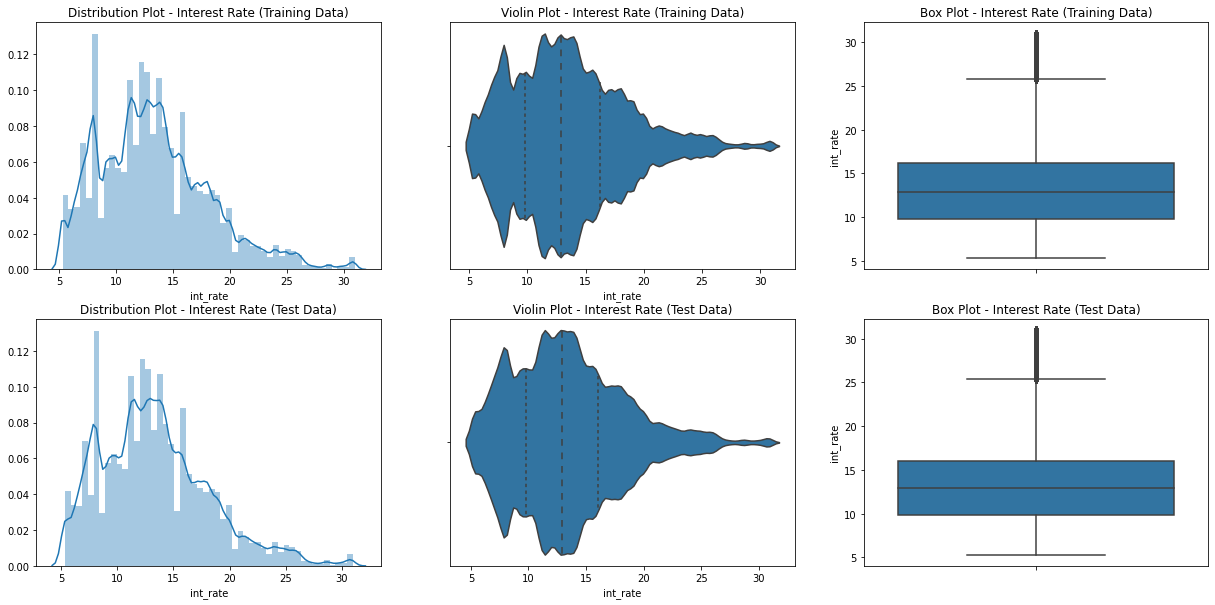

In [16]:
# Plotting for Interest rate, in training dataset
fig, ax = plt.subplots(2,3,figsize=(21,10))
ax[0][0].set_title("Distribution Plot - Interest Rate (Training Data)")
sns.distplot(df_train['int_rate'],ax=ax[0][0])
ax[0][1].set_title("Violin Plot - Interest Rate (Training Data)")
sns.violinplot(data=df_train, x='int_rate',ax=ax[0][1], inner="quartile")
ax[0][2].set_title("Box Plot - Interest Rate (Training Data)")
sns.boxplot(data=df_train, x='int_rate',ax=ax[0][2],orient='v')

# Plottting for Interest Rate, in test dataset
ax[1][0].set_title("Distribution Plot - Interest Rate (Test Data)")
sns.distplot(df_test['int_rate'],ax=ax[1][0])
ax[1][1].set_title("Violin Plot - Interest Rate (Test Data)")
sns.violinplot(data=df_test, x='int_rate',ax=ax[1][1], inner="quartile")
ax[1][2].set_title("Box Plot - Interest Rate (Test Data)")
sns.boxplot(data=df_test, x='int_rate',ax=ax[1][2],orient='v')

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_train_int_rate = boxplot_stats(df_train['int_rate']).pop(0)['fliers']
df_train = df_train[~df_train['int_rate'].isin(outlier_train_int_rate)]
print (df_train.shape)

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_test_int_rate = boxplot_stats(df_test['int_rate']).pop(0)['fliers']
df_test = df_test[~df_test['int_rate'].isin(outlier_test_int_rate)]
print (df_test.shape)

(900481, 90)
(299343, 90)


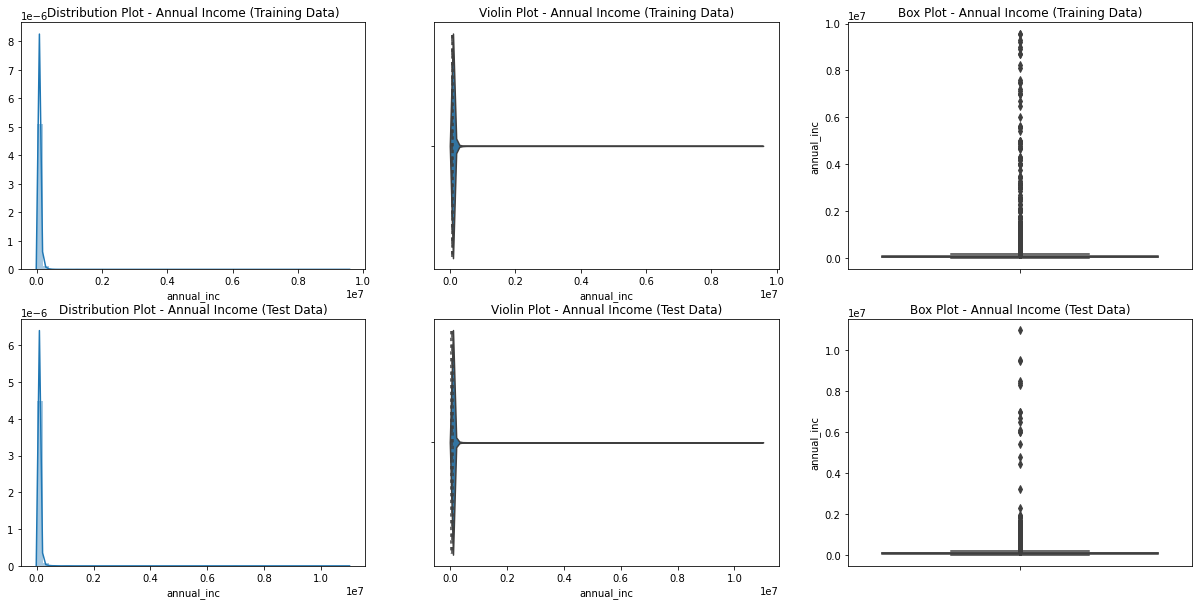

In [17]:
# Optional to run this cell twice, as there are some extreme outliers that need to be removed in the first pass
# Plotting for Annual income, in training dataset
fig, ax = plt.subplots(2,3,figsize=(21,10))
ax[0][0].set_title("Distribution Plot - Annual Income (Training Data)")
sns.distplot(df_train['annual_inc'],ax=ax[0][0])
ax[0][1].set_title("Violin Plot - Annual Income (Training Data)")
sns.violinplot(data=df_train, x='annual_inc',ax=ax[0][1], inner="quartile")
ax[0][2].set_title("Box Plot - Annual Income (Training Data)")
sns.boxplot(data=df_train, x='annual_inc',ax=ax[0][2],orient='v')

# Plottting for Annual Income, in test dataset
ax[1][0].set_title("Distribution Plot - Annual Income (Test Data)")
sns.distplot(df_test['annual_inc'],ax=ax[1][0])
ax[1][1].set_title("Violin Plot - Annual Income (Test Data)")
sns.violinplot(data=df_test, x='annual_inc',ax=ax[1][1], inner="quartile")
ax[1][2].set_title("Box Plot - Annual Income (Test Data)")
sns.boxplot(data=df_test, x='annual_inc',ax=ax[1][2],orient='v')

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_train_annual_inc = boxplot_stats(df_train['annual_inc']).pop(0)['fliers']
df_train = df_train[~df_train['annual_inc'].isin(outlier_train_annual_inc)]
print (df_train.shape)

# Extract outliers from the boxplot and remove the rows from training dataset
outlier_test_annual_inc = boxplot_stats(df_test['annual_inc']).pop(0)['fliers']
df_test = df_test[~df_test['annual_inc'].isin(outlier_test_annual_inc)]
print (df_test.shape)

In [18]:
print (df_train.loan_amnt.describe())
print (df_train.int_rate.describe())
print (df_train.annual_inc.describe())

count    900481.000000
mean      13921.321605
std        8243.886161
min        1000.000000
25%        7600.000000
50%       12000.000000
75%       19750.000000
max       38000.000000
Name: loan_amnt, dtype: float64
count    900481.000000
mean         13.171146
std           4.427621
min           5.310000
25%           9.920000
50%          12.790000
75%          15.990000
max          25.780000
Name: int_rate, dtype: float64
count    900481.000000
mean      68001.149052
std       30149.642421
min           0.000000
25%       45000.000000
50%       62500.000000
75%       85000.000000
max      156000.000000
Name: annual_inc, dtype: float64


### Observation (continuous variable)
* After removing the outliers, we can see that most of the loans have loan amount between 8000-20000 USD 
* Most of the loans have interest rate between 5-15% 
* Most of the borrowers have annual income between 45000 to 90000 USD



## Univariate Analysis - Categorical variables
Next we investigate on some of the key categorical variables, namely Loan status, Purpose, Home Ownership, and Term of the loan

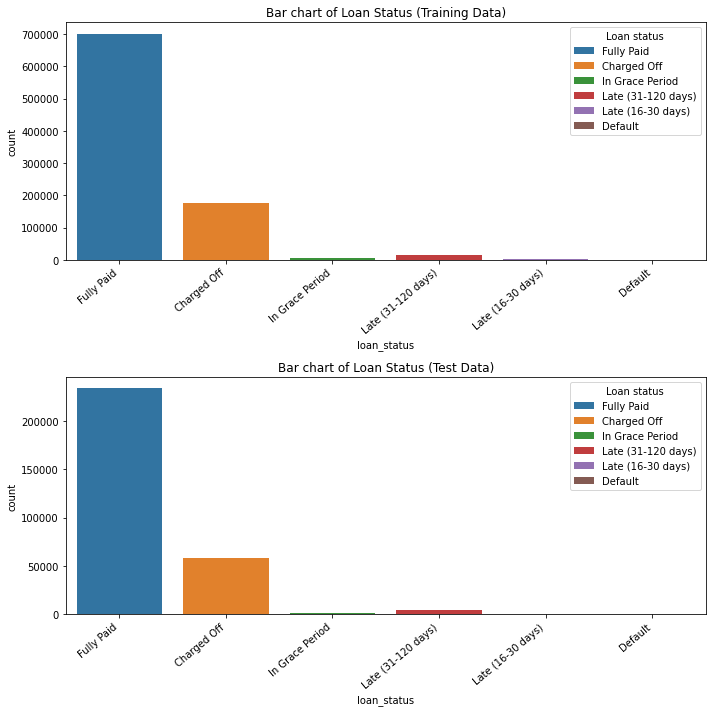

In [19]:
# Plot for Loan Status
f, ax = plt.subplots(2,1,figsize=(10,10))
labels=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Status - training data
# print (df_train.loan_status.value_counts(normalize=True))
sns.countplot(data = df_train, x='loan_status', hue='loan_status', order = labels, hue_order=labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels,title="Loan status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan Status (Training Data)")

# Plot for Loan Status - test data
# print (df_test.loan_status.value_counts(normalize=True))
sns.countplot(data = df_test, x='loan_status', hue='loan_status', order = labels, hue_order=labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels,title="Loan status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan Status (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Loan Status
* Without considering loans that are "Current", the dataset is still quite imbalanced. Majority of the loans are fully paid, and bad loans account for a relatively small percentage of the total loans (~22%)

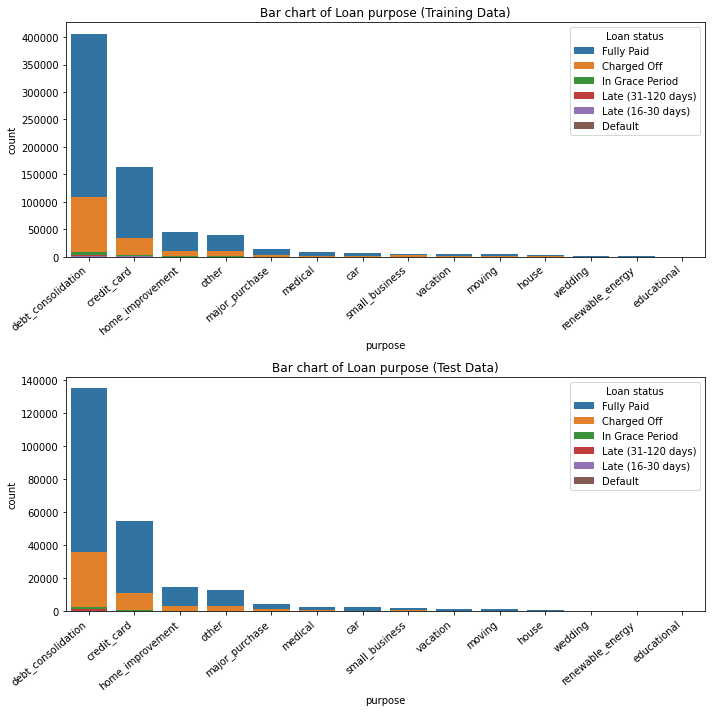

(900480, 90)
(299343, 90)


In [20]:
# Plot for Loan purpose 
f, ax = plt.subplots(2,1,figsize=(10,10))
labels = list(df_train.purpose.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan purpose - training data
# print (df_train.purpose.value_counts(normalize=True))
sns.countplot(data = df_train, x='purpose', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan purpose (Training Data)")

# Plot for Loan purpose - test data
# print (df_test.purpose.value_counts(normalize=True))
sns.countplot(data = df_test, x='purpose', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan purpose (Test Data)")

plt.tight_layout()
plt.show()

# Remove loans that are for "educational" purpose as they are not very representative of the larger dataset
df_train = df_train[df_train['purpose']!='educational']
df_test = df_test[df_test['purpose']!='educational']
print (df_train.shape)
print (df_test.shape)

### Observation - Purpose
* Close to 60% of the loans are applied for debt consolidation purpose, i.e. to repay other debt.
* Some of the loan purposes account for a minimal percentage, e.g. educational. These can be removed. 

MORTGAGE    0.486374
RENT        0.404353
OWN         0.108990
ANY         0.000213
NONE        0.000038
OTHER       0.000032
Name: home_ownership, dtype: float64
MORTGAGE    0.486562
RENT        0.404305
OWN         0.108828
ANY         0.000217
OTHER       0.000050
NONE        0.000037
Name: home_ownership, dtype: float64
(900225, 90)
(299252, 90)


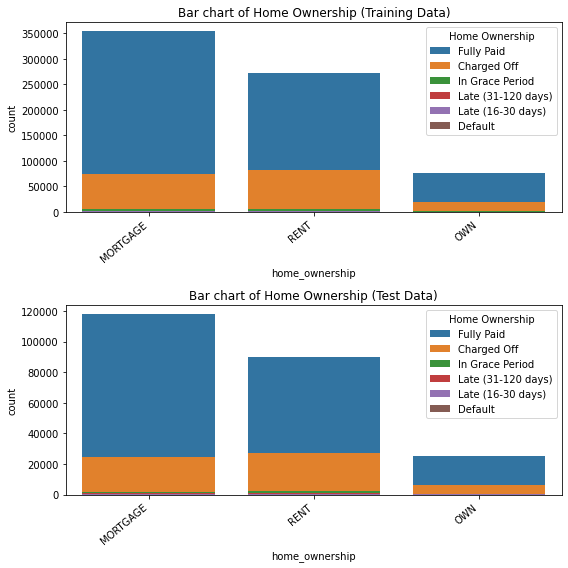

In [21]:
# Plot for Home ownership column
print (df_train.home_ownership.value_counts(normalize=True))
print (df_test.home_ownership.value_counts(normalize=True))
# Remove rows that are a very small proportion of the total loans
to_remove = ['ANY','NONE','OTHER']
df_train = df_train[~df_train.home_ownership.isin(to_remove)]
df_test = df_test[~df_test.home_ownership.isin(to_remove)]
print (df_train.shape)
print (df_test.shape)

f, ax = plt.subplots(2,1,figsize=(8,8))
labels = list(df_train.home_ownership.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan purpose - training data
# print (df_train.purpose.value_counts(normalize=True))
sns.countplot(data = df_train, x='home_ownership', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Home Ownership", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Home Ownership (Training Data)")

# Plot for Loan Status - test data
# print (df_test.purpose.value_counts(normalize=True))
sns.countplot(data = df_test, x='home_ownership', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Home Ownership", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Home Ownership (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Homeownership
* Majority of the loans are registered with these home ownership status: _['MORTGAGE','RENT','OWN']_. Hence we will remove rows with the rest of the statuses: ['ANY','NONE','OTHER']
* We can see that if the borrower is renting a home, there is a higher chance of bad loan, compared to if the borrower owns the home / is under mortgage.

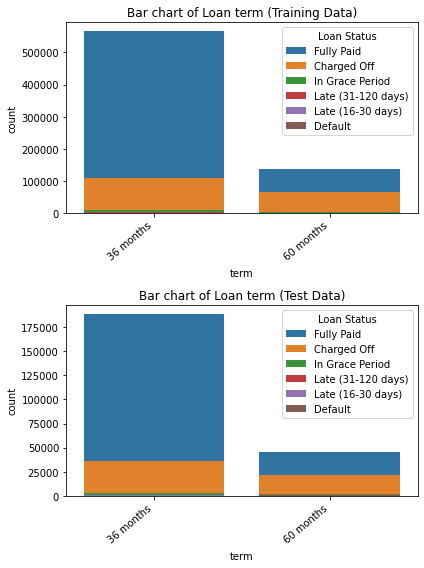

In [22]:
# Plot for Loan Term
f, ax = plt.subplots(2,1,figsize=(6,8))
labels = list(df_train.term.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Term - training data
sns.countplot(data = df_train, x='term', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan term (Training Data)")

# Plot for Loan Term - test data
sns.countplot(data = df_test, x='term', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan term (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Term
* We can see that loans with a longer term (i.e. 60 months) are more likely to be bad loan

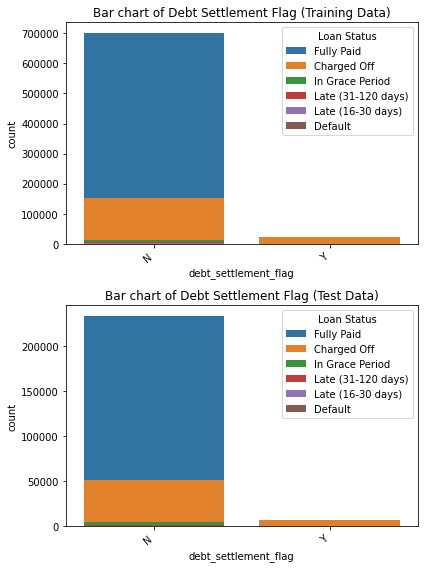

In [23]:
# Plot for Debt Settlement Flag, which indicates whether or not the borrower, who has charged off, is working with a debt-settlement company
f, ax = plt.subplots(2,1,figsize=(6,8))
labels = list(df_train.debt_settlement_flag.value_counts().index)
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Debt Settlement Flag - training data
sns.countplot(data = df_train, x='debt_settlement_flag', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Debt Settlement Flag (Training Data)")

# Plot for Debt Settlement Flag - test data
sns.countplot(data = df_test, x='debt_settlement_flag', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Debt Settlement Flag (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Debt Settlement Flag
* From a business perspective, the debt settlement flag only applies if a loan has already been charged off.
* Therefore, this flag is an outcome of the loan status, and hence we should not use it for determining a bad loan.

In [24]:
# Remove Debt Settlement Flag
df_train.drop(columns='debt_settlement_flag',inplace=True)
df_test.drop(columns='debt_settlement_flag',inplace=True)
print (df_train.shape)
print (df_test.shape)

(900225, 89)
(299252, 89)


### Observation - Payment Plan
* Another similar column is _pymnt_plan_ , from a business perspective, payment plan only applies if the loan is late, which indicates it is bad loan. Hence, we should not use _pymnt_plan_ for our prediction. 

In [25]:
print (df_train[df_train.pymnt_plan=='y']['loan_status'].value_counts())
print (df_test[df_test.pymnt_plan=='y']['loan_status'].value_counts())
# Remove Payment plan column
df_train.drop(columns='pymnt_plan',inplace=True)
df_test.drop(columns='pymnt_plan',inplace=True)
print (df_train.shape)
print (df_test.shape)

Late (31-120 days)    430
Late (16-30 days)       7
In Grace Period         2
Name: loan_status, dtype: int64
Late (31-120 days)    142
Late (16-30 days)       2
In Grace Period         1
Name: loan_status, dtype: int64
(900225, 88)
(299252, 88)


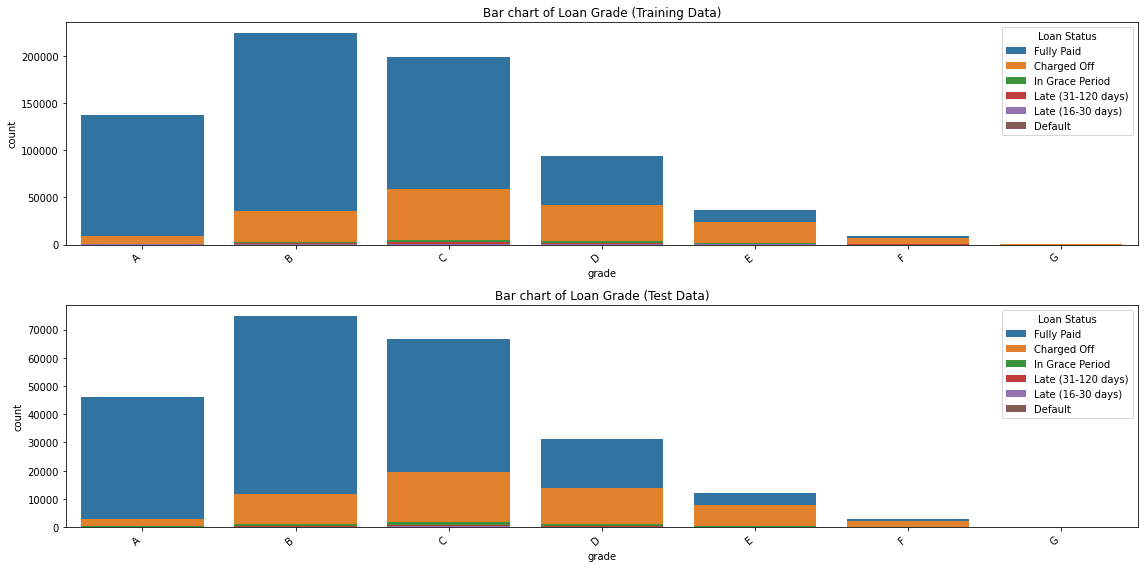

In [26]:
# Plot for Grade
f, ax = plt.subplots(2,1,figsize=(16,8))
labels = ['A','B','C','D','E','F','G']
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Grade - training data
sns.countplot(data = df_train, x='grade', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan Grade (Training Data)")

# Plot for Loan Grade - test data
sns.countplot(data = df_test, x='grade', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan Grade (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Grade
* It would be common sense that the lower the grade the loan is, the higher the chance that it is a bad loan. This is indeed the case in above plot. 
* However, this raises the question whether _grade_ can be used for prediction, since this is the grade assigned by Lending Club itself, based on their prediction of the loan

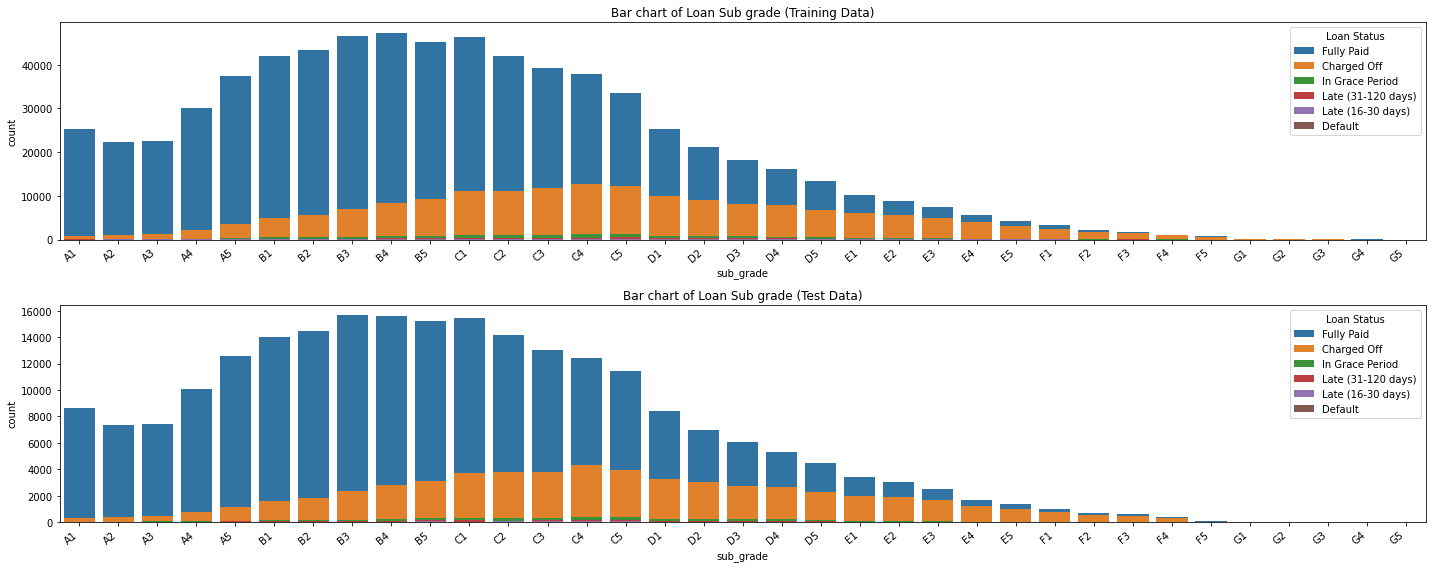

In [27]:
# Plot for Sub grade
f, ax = plt.subplots(2,1,figsize=(20,8))
labels = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3','C4','C5',\
          'D1','D2','D3','D4','D5','E1','E2','E3','E4','E5','F1','F2','F3','F4','F5','G1','G2','G3','G4','G5']
labels_status=["Fully Paid", "Charged Off",  "In Grace Period", "Late (31-120 days)", "Late (16-30 days)", "Default"]

# Plot for Loan Grade - training data
sns.countplot(data = df_train, x='sub_grade', hue='loan_status', order = labels, dodge=False ,ax=ax[0])
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title("Bar chart of Loan Sub grade (Training Data)")

# Plot for Loan Grade - test data
sns.countplot(data = df_test, x='sub_grade', hue='loan_status', order = labels, dodge=False ,ax=ax[1])
h,l = ax[1].get_legend_handles_labels()
ax[1].legend(h,labels_status,title="Loan Status", loc="upper right") 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title("Bar chart of Loan Sub grade (Test Data)")

plt.tight_layout()
plt.show()

### Observation - Sub Grade
* Similar to grade, we can see that the lower the sub-grade assigned by Lending Club, the higher the proportions of loans identified as bad loans. 
* For now, we will keep both Grade & Sub grade for prediction purpose.

## Bivariate/Multivariate Analysis
Next, we will perform some analysis between variables, to investigate their relationship, for further findings before prediction. The analysis will be done on both the training and the test dataset.

For example, in below analysis, we try to investigate relationship between __categorical variables__, such as _Loan Purpose, Employment Length, Loan Status_ and __continuous variable__ - _Loan Amount_

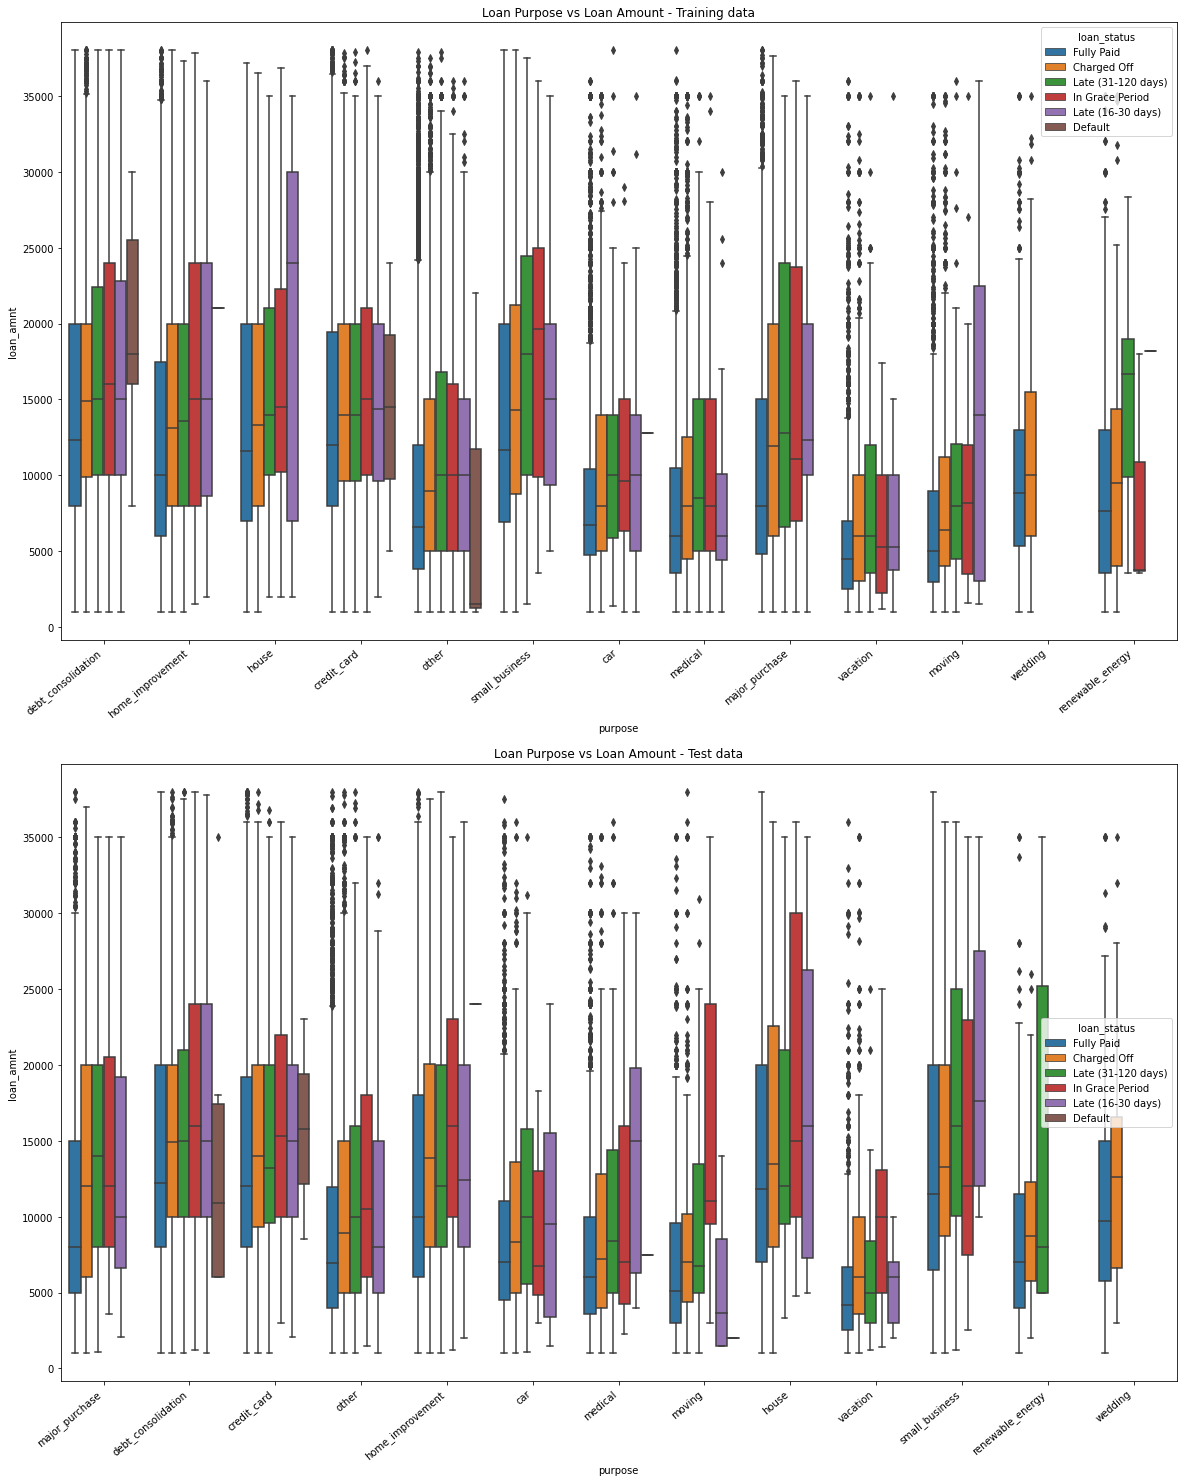

In [28]:
# Analysis and Purpose of the loan v.s. Loan amount
f, ax = plt.subplots(2,1,figsize=(20,25))

# Plot for training dataset
sns.boxplot(data=df_train, x='purpose', y='loan_amnt', hue ='loan_status',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Loan Purpose vs Loan Amount - Training data')

# Plot for test dataset
sns.boxplot(data=df_test, x='purpose', y='loan_amnt', hue ='loan_status',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title('Loan Purpose vs Loan Amount - Test data')
plt.show()

### Observation
* From above plot, we can see that some of the common purposes that give rise to high loan amount are: _debt_consolidation, house, and small_business_
* Most of the Loan defaults happens for loan purposes such as _credit_card, debt_consolidation & other_

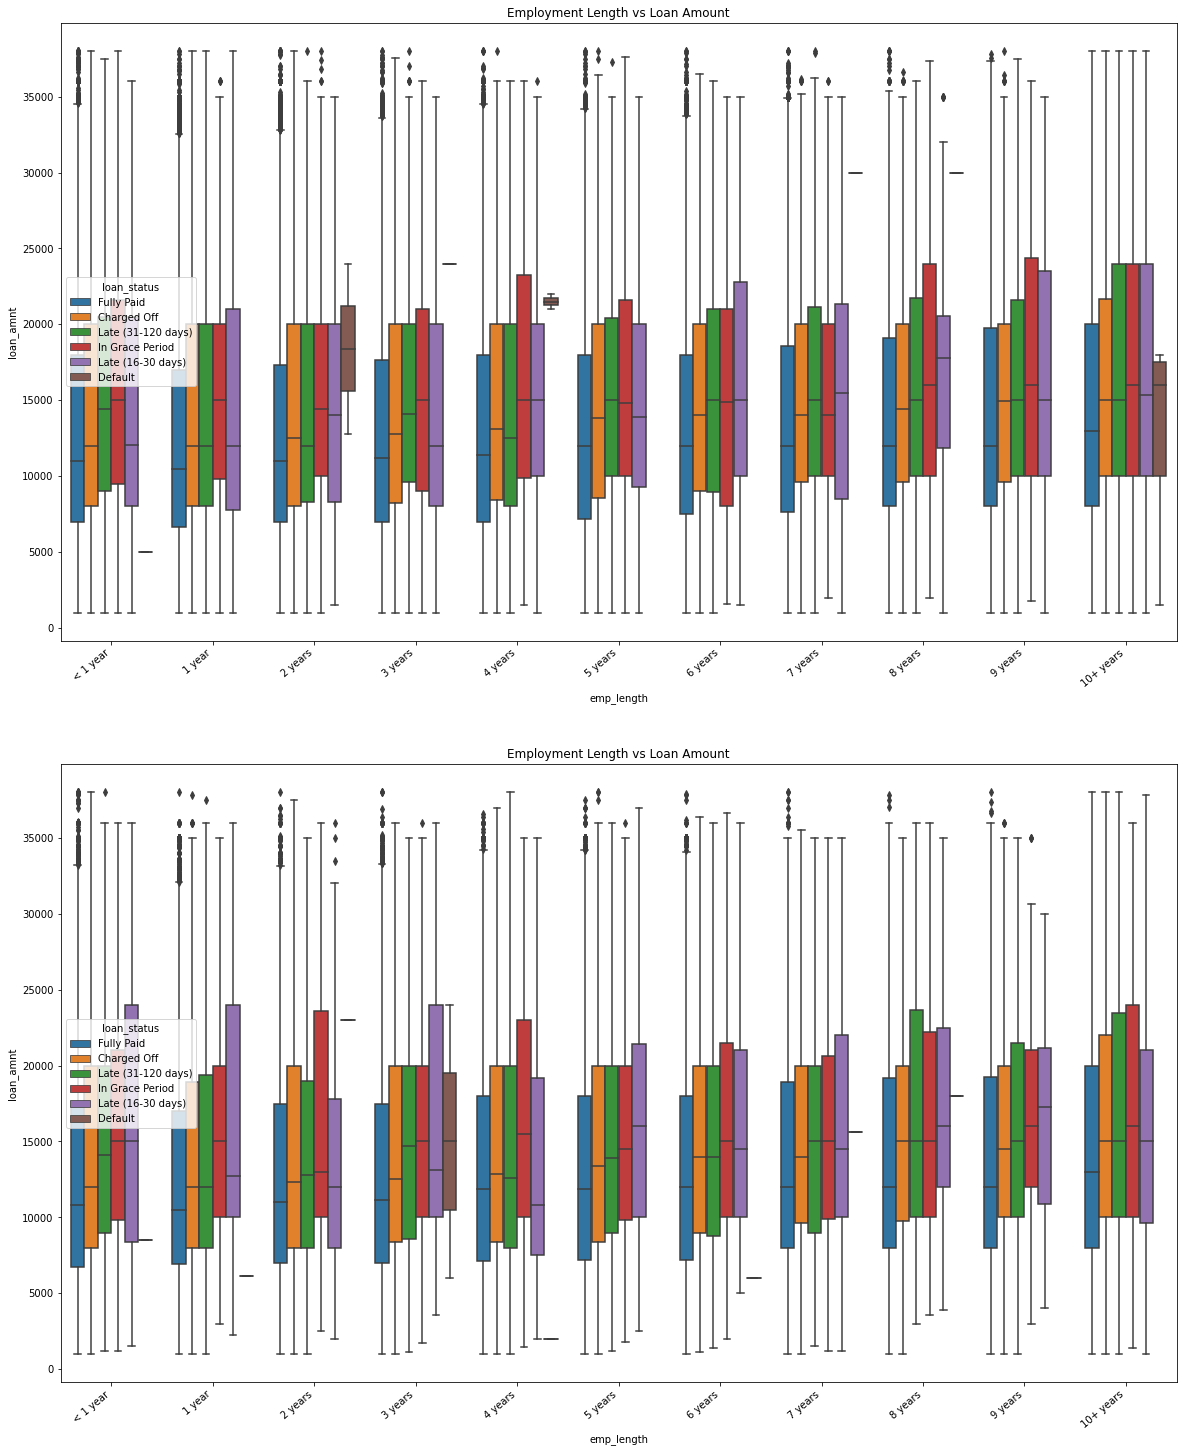

In [29]:
# Analysis and Employment Length v.s. Loan amount
f, ax = plt.subplots(2,1,figsize=(20,25))
labels = ['< 1 year','1 year','2 years','3 years','4 years','5 years','6 years','7 years','8 years','9 years','10+ years']

# Plot for training dataset
sns.boxplot(data=df_train, x='emp_length', y='loan_amnt', order=labels, hue ='loan_status',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=40, ha="right")
ax[0].set_title('Employment Length vs Loan Amount')

# Plot for test dataset
sns.boxplot(data=df_test, x='emp_length', y='loan_amnt', order=labels, hue ='loan_status',ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=40, ha="right")
ax[1].set_title('Employment Length vs Loan Amount')
plt.show()

### Observation
* Initially, we thought the less number of years employed, the more likely the borrower will apply for loans with larger amount. However, this is not the case except there are more outliers with exceptional large loan amounts, for borrowers with shorter employment length.
* In terms of the risk, we can see that borrowers with less employment length does not necessarily mean more risks of the loan. We can see the proportion of loans fully paid to be about the same amongst various employment lengths.

Next, we try to investigate the __correlation among continuous variables__ in the dataset. If two or more variables are high correlated, we should just keep one of the variables during training and prediction

In [30]:
train_corr = df_train.corr()
train_corr

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,issue_y,issue_m,loan_to_income_ratio
loan_amnt,1.000000,0.999986,0.999977,0.143727,0.951819,0.458708,0.053008,-0.006893,-0.023324,0.173757,...,0.034238,-0.096642,-0.002567,0.298972,0.243228,0.347399,0.164524,-0.021693,-0.021543,0.003804
funded_amnt,0.999986,1.000000,0.999992,0.143705,0.951833,0.458705,0.053009,-0.006889,-0.023331,0.173757,...,0.034235,-0.096635,-0.002564,0.298972,0.243229,0.347408,0.164524,-0.021639,-0.021546,0.003804
funded_amnt_inv,0.999977,0.999992,1.000000,0.143700,0.951792,0.458739,0.052961,-0.006893,-0.023317,0.173757,...,0.034179,-0.096616,-0.002570,0.298993,0.243229,0.347432,0.164526,-0.021428,-0.021604,0.003801
int_rate,0.143727,0.143705,0.143700,1.000000,0.147309,-0.115773,0.136880,0.044661,0.216745,-0.009465,...,0.263276,0.051424,0.010726,-0.118427,0.015510,-0.237075,0.001742,-0.064794,0.003856,-0.000303
installment,0.951819,0.951833,0.951792,0.147309,1.000000,0.434084,0.055061,0.001811,-0.000609,0.161973,...,0.053614,-0.089837,0.003357,0.259976,0.223616,0.313102,0.146758,-0.024329,-0.023644,0.003774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
total_bc_limit,0.347399,0.347408,0.347432,-0.237075,0.313102,0.332130,0.052158,-0.077150,-0.010212,0.355977,...,-0.227002,-0.153485,-0.028379,0.346365,0.223576,1.000000,0.065049,0.046152,-0.006135,0.002895
total_il_high_credit_limit,0.164524,0.164524,0.164526,0.001742,0.146758,0.334649,0.292942,0.062884,0.040200,0.358126,...,0.014093,-0.028443,-0.000798,0.365543,0.896511,0.065049,1.000000,0.071718,-0.001974,-0.001423
issue_y,-0.021693,-0.021639,-0.021428,-0.064794,-0.024329,0.028528,0.044390,0.015649,-0.083867,0.021776,...,-0.165789,0.053905,0.020124,0.030061,0.047690,0.046152,0.071718,1.000000,-0.187063,0.001964
issue_m,-0.021543,-0.021546,-0.021604,0.003856,-0.023644,-0.009363,-0.002402,0.003617,-0.001558,-0.009647,...,-0.002286,-0.007024,-0.008994,-0.003451,-0.003564,-0.006135,-0.001974,-0.187063,1.000000,0.001143


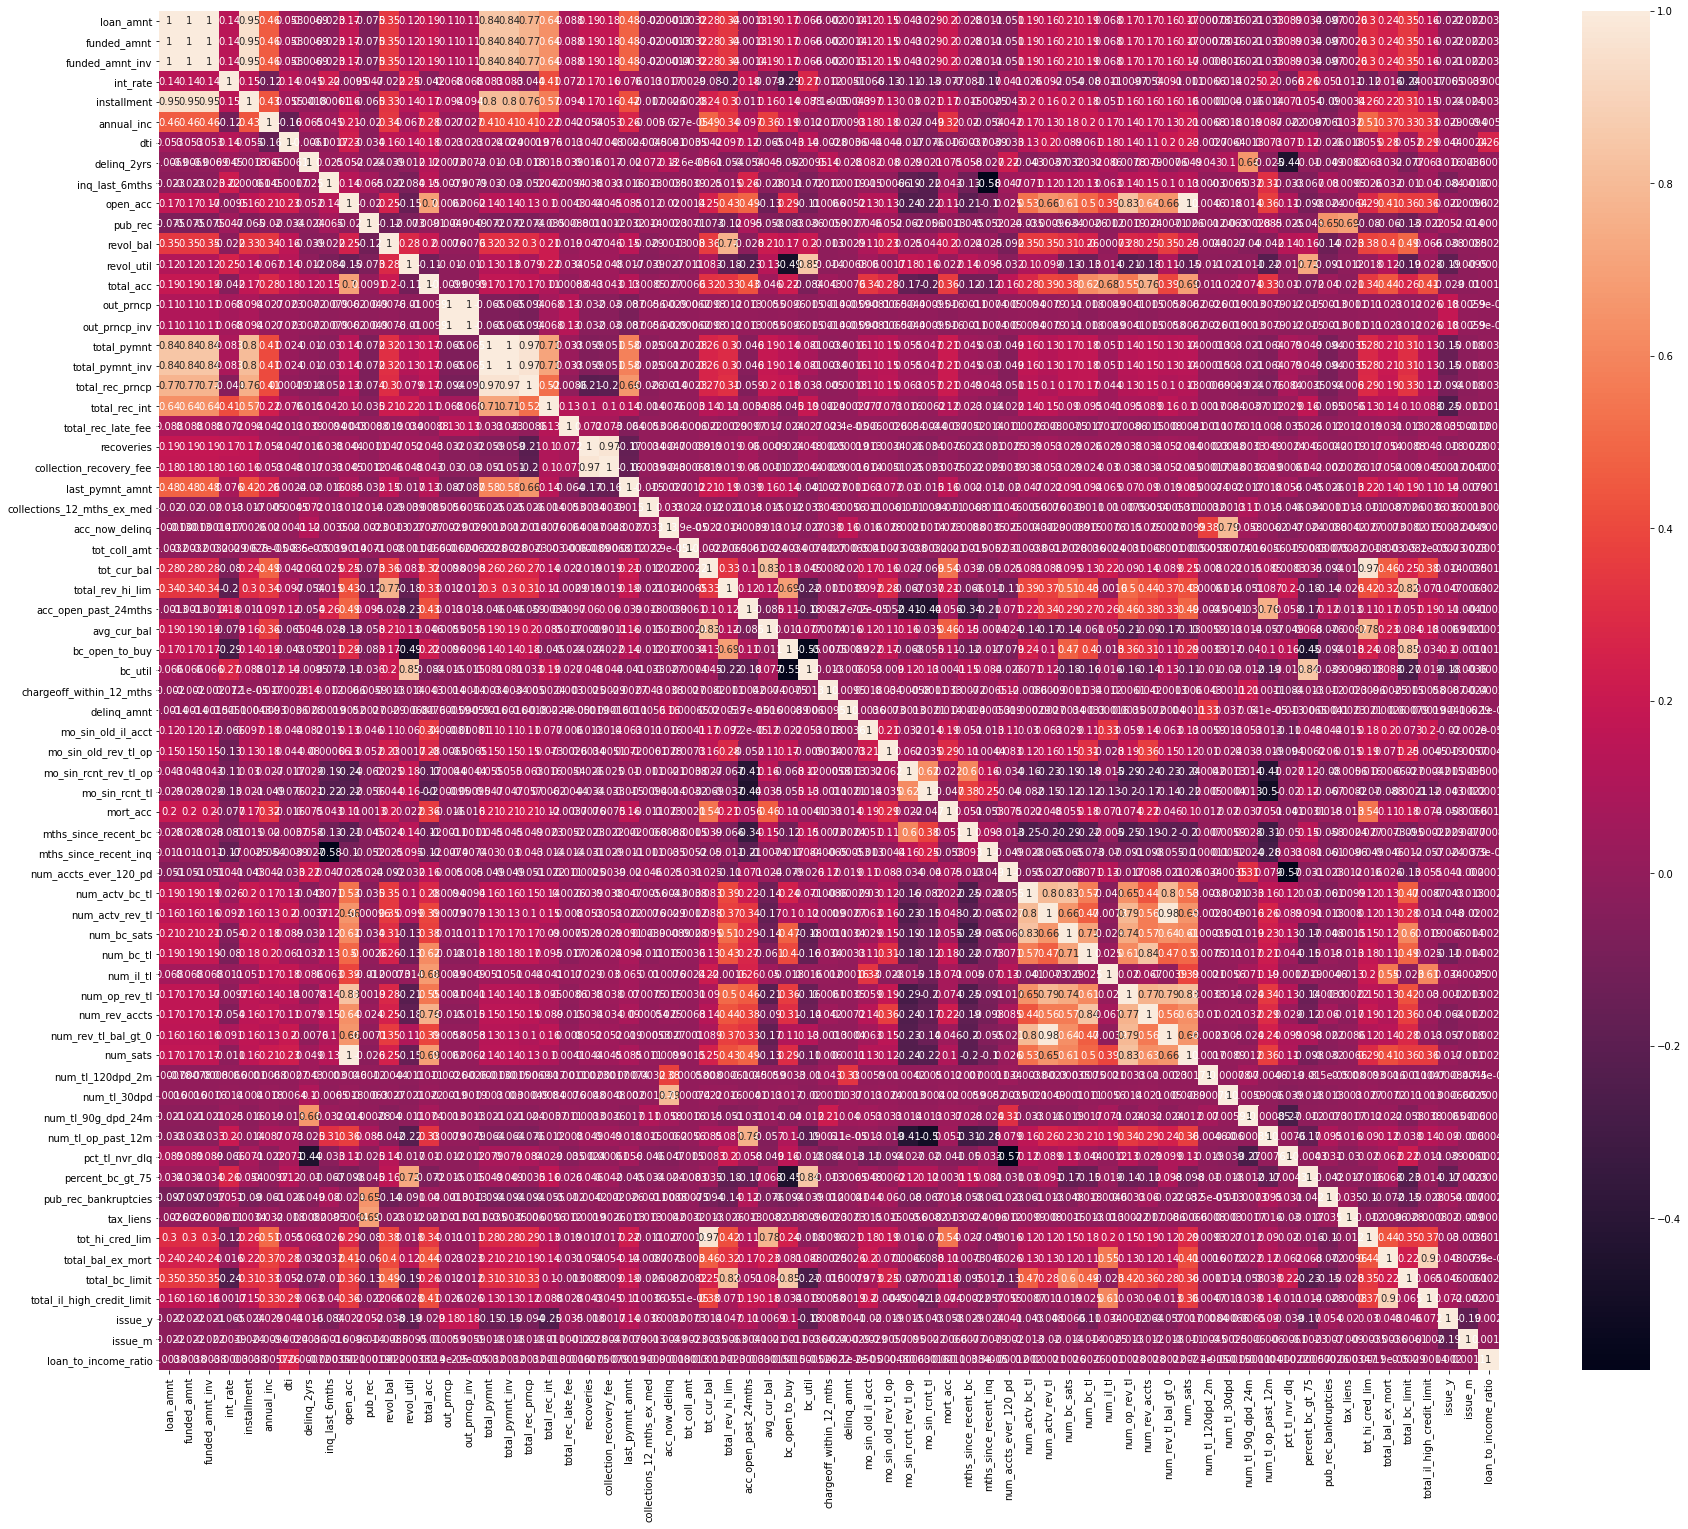

In [31]:
f, ax = plt.subplots(figsize=(30, 25))
sns.heatmap(train_corr, 
            xticklabels=train_corr.columns.values,
            yticklabels=train_corr.columns.values,annot= True)
plt.show()

### Observation
We inspect which columns have correlation score of >=0.90 or <= -0.90, and remove the redundant columns, for both training and test set.
* As we have previously suspected, _[loan_amnt, funded_amnt, funded_amnt_inv]_ are highly correlated. We can thus keep __loan_amnt__ only, for our prediction model
* Similarly, _[total_pymnt, total_pymnt, total_rec_int]_ are highly correlated, as all these indicate the total payment received to date. Hence, we can keep __total_pymnt__ column only. 
* _[num_sats, open_acc]_ are also perfectly correlated as both indicate the number of accounts already opened by the borrower. We can thus keep __open_acc__ only.
* _[tot_cur_bal, tot_hi_cred_lim]_ are highly correlated as both indicate the total credit limit / current balance of the borrower. We will keep __total_cur_bal__, for our prediction purpose
* _[num_actv_rev_tl, num_rev_tl_bal_gt_0]_ are both linked to the number of revolving trade, and highly correlated. We will ony keep __num_actv_rev_tl__ in this case.
* _[out_prncp, out_prncp_inv]_ are both related to remaining outstanding principal amounts. Since they are highly correlated, we will just keep __out_prncp__ for prediction purpose
* _[recoveries, collection_recovery_fee]_ are both related to recoveries post charge-off. Upon checking the data dictionary, we have decided to remove both columns as they are outcomes of a loan charge-off
* _[total_pymnt_inv, total_rec_prncp]_ are highly correlated (0.97), as both are related to the total principal amount. Hence, we will keep __total_rec_prncp__
* _[installment, loan_amnt]_ are highly correlated (0.95). Hence, we will remove installment, and keep __loan_amnt__.
* _[total_bal_ex_mort, total_il_high_credit_limit]_ are highly correlated as both are tied to the remaining credit balance. We will keep __total_il_high_credit_limit__

In [32]:
redundant_cols = ['funded_amnt', 'funded_amnt_inv', 'total_pymnt', \
                  'total_rec_int', 'num_sats', 'tot_hi_cred_lim','num_rev_tl_bal_gt_0',\
                  'out_prncp_inv','recoveries','collection_recovery_fee',\
                  'total_pymnt_inv','installment','total_bal_ex_mort']
df_train.drop(columns=redundant_cols, inplace=True)
df_test.drop(columns=redundant_cols, inplace=True)

print (df_train.shape)
print (df_test.shape)

(900225, 75)
(299252, 75)


## Keep only useful columns for prediction
Now, we still have a lot of columns left, some of which might not necessarily have an impact when predicting whether the loan is a good / bad loan. 

For this, we checked each column and its definition in the accompanying Data Dictionary (LCDataDictionary.xlsx). Based on the previous exploratory analysis and our judgement, we select only a handful of columns to keep for our prediction problem.

In [33]:
# # Load the accomanying data dictionary with column description
# df_description = pd.read_excel('data/LCDataDictionary.xlsx').dropna()
# df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})
cols_to_keep = ['loan_amnt','annual_inc','int_rate','term','grade','sub_grade','emp_length','home_ownership','verification_status',\
                'issue_d','issue_m','issue_y','loan_status','purpose','addr_state','dti','delinq_2yrs','earliest_cr_line',\
                'pub_rec','revol_util','out_prncp','total_rec_late_fee','last_pymnt_d','last_credit_pull_d',\
                'collections_12_mths_ex_med','acc_now_delinq','tot_coll_amt','total_rev_hi_lim',\
                'acc_open_past_24mths','bc_util','chargeoff_within_12_mths','mort_acc','num_accts_ever_120_pd',\
                'num_actv_rev_tl','num_tl_120dpd_2m','num_tl_30dpd','num_tl_90g_dpd_24m','pct_tl_nvr_dlq',\
                'pub_rec_bankruptcies','tax_liens','hardship_flag','disbursement_method',\
                'region','loan_condition','loan_to_income_ratio','emp_title','title',\
                'open_acc','application_type','delinq_amnt','num_actv_bc_tl','total_il_high_credit_limit']
df_train = df_train[cols_to_keep]
df_test = df_test[cols_to_keep]
print (df_train.shape)
print (df_test.shape)

(900225, 52)
(299252, 52)


For categorical variables, we are not able to plot the correlation. However, we can check how many unique values are there for each variable. 
* If there are too many unique values, it might not make sense to use that column for prediction, e.g. emp_title, title. 
* If there are only 2 unique values, then we can label encode the column for prediction
* If there are more than 2 unique values, we need to perform one-hot encoding on the column

In [34]:
print (df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0))
df_train.drop(columns=['emp_title','title'],inplace=True)
df_test.drop(columns=['emp_title','title'],inplace=True)

term                        2
grade                       7
sub_grade                  35
emp_length                 12
home_ownership              3
verification_status         3
issue_d                    82
loan_status                 6
purpose                    13
addr_state                 51
earliest_cr_line          725
last_pymnt_d               82
last_credit_pull_d         84
hardship_flag               2
disbursement_method         2
region                      5
loan_condition              2
emp_title              263790
title                   33431
application_type            2
dtype: int64


Some of these categorical variables are actually __dates__ in the format of _month-year_ , so we will need to process them into a format that can be consumed by the model
* First, we convert these date variables into python datetime format
* Next, we calculate the number of elapsed months from the date to 2018-12-01, which we assume to be the current date here
* For then date variables, we will fill the na columns with the max # of months elapsed until 2018-12-01

Also, for __all continuous variables__, we will fill the null values with the __medians__.

In [35]:
df_train.fillna(df_train.median(),inplace=True)
df_test.fillna(df_test.median(),inplace=True) 
df_train.info(null_counts=True, verbose=True)
df_test.info(null_counts=True, verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900225 entries, 1832470 to 868271
Data columns (total 50 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   900225 non-null  int64  
 1   annual_inc                  900225 non-null  float64
 2   int_rate                    900225 non-null  float64
 3   term                        900225 non-null  object 
 4   grade                       900225 non-null  object 
 5   sub_grade                   900225 non-null  object 
 6   emp_length                  900225 non-null  object 
 7   home_ownership              900225 non-null  object 
 8   verification_status         900225 non-null  object 
 9   issue_d                     900225 non-null  object 
 10  issue_m                     900225 non-null  int64  
 11  issue_y                     900225 non-null  int64  
 12  loan_status                 900225 non-null  object 
 13  purpose 

In [36]:
# For Date columns, we perform the follow:
# 1 - convert it into python datetime format
# 2 - calculate the # months elapsed from the date to 2018-12-01
# 3 - fill the na values with the max # of months elapsed

def col_to_datetime(df, col):
    return pd.to_datetime(df[col], format='%b-%Y', errors='coerce')

    
date_cols = ['issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d']#,]

for col in date_cols:
    df_train[col] = col_to_datetime(df_train, col)
    df_test[col] = col_to_datetime(df_test, col)
    print ("%s converted to datetime"%col)

df_train['ref_date'] = pd.to_datetime('2018-12-01', format='%Y-%m-%d')
df_test['ref_date'] = pd.to_datetime('2018-12-01', format='%Y-%m-%d')

for col in date_cols:
    df_train[col] = (df_train['ref_date']- df_train[col]).dt.days/30
    df_test[col] = (df_test['ref_date']-df_test[col]).dt.days/30
    print ("%s calculated in # month"%col)

df_train.drop(columns='ref_date',inplace=True)
df_test.drop(columns='ref_date',inplace=True)

# Fill null values with the max # of months elapsed
df_train['last_pymnt_d'].fillna(df_train['last_pymnt_d'].max(),inplace=True)
df_train['last_credit_pull_d'].fillna(df_train['last_credit_pull_d'].max(),inplace=True)
df_test['last_pymnt_d'].fillna(df_test['last_pymnt_d'].max(),inplace=True)
df_test['last_credit_pull_d'].fillna(df_test['last_credit_pull_d'].max(),inplace=True)  
print ("fill na completed")

issue_d converted to datetime
earliest_cr_line converted to datetime
last_pymnt_d converted to datetime
last_credit_pull_d converted to datetime
issue_d calculated in # month
earliest_cr_line calculated in # month
last_pymnt_d calculated in # month
last_credit_pull_d calculated in # month
fill na completed


In [37]:
print (df_train.shape)
print (df_test.shape)
print (df_train.isnull().sum())

(900225, 50)
(299252, 50)
loan_amnt                     0
annual_inc                    0
int_rate                      0
term                          0
grade                         0
sub_grade                     0
emp_length                    0
home_ownership                0
verification_status           0
issue_d                       0
issue_m                       0
issue_y                       0
loan_status                   0
purpose                       0
addr_state                    0
dti                           0
delinq_2yrs                   0
earliest_cr_line              0
pub_rec                       0
revol_util                    0
out_prncp                     0
total_rec_late_fee            0
last_pymnt_d                  0
last_credit_pull_d            0
collections_12_mths_ex_med    0
acc_now_delinq                0
tot_coll_amt                  0
total_rev_hi_lim              0
acc_open_past_24mths          0
bc_util                       0
chargeoff_with

## Normalize the continuous variable
Next, we normalize the continues variables, before splitting the training and test datasets into x variables and y labels.

As a first step, we need to remove the outliers for these continuous variables. Outliers are values beyond 3 standard deviation away from the mean of the column. 
* We will skip certain columns (e.g. _loan_amnt, annual_inc, int_rate_ ), for which we have already removed outliers in earliers steps.
* Also, for _loan_to_income_ratio_, we have a lot of records with value=inf, this is due to annual_inc = 0. We  replace these with the max loan_to_income ratio

In [38]:
# Replace infinity value in loan_to_income_ratio with the max value excluding infinity
max_non_inf = df_train.loan_to_income_ratio.replace(np.inf, np.nan).max()
df_train.loan_to_income_ratio.replace(np.inf, max_non_inf, inplace=True)
df_test.loan_to_income_ratio.replace(np.inf, max_non_inf, inplace=True)

def remove_outlier(col, df):
    # keep only the ones that are within +3 to -3 standard deviations in 'col'.
    df = df[np.abs(df[col]-df[col].mean()) <= (3*df[col].std())]
    return df
    
cols = ['loan_to_income_ratio','dti','out_prncp','total_il_high_credit_limit','total_rec_late_fee',\
        'tot_coll_amt','total_rev_hi_lim','delinq_amnt',\
      'delinq_2yrs','open_acc','num_actv_bc_tl','num_actv_rev_tl','num_tl_120dpd_2m',\
        'num_tl_30dpd','num_tl_90g_dpd_24m','pct_tl_nvr_dlq','pub_rec_bankruptcies','tax_liens','pub_rec',\
        'revol_util','collections_12_mths_ex_med','acc_now_delinq',\
        'acc_open_past_24mths','bc_util','chargeoff_within_12_mths',\
        'mort_acc','num_accts_ever_120_pd']
        
for col in cols:
    df_train = remove_outlier(col, df_train)
    df_test = remove_outlier(col, df_test)

print (df_train.shape)
print (df_test.shape)

(677165, 50)
(225421, 50)


In [39]:
print (df_train.describe())
print (df_train.shape)
print (df_test.shape)

           loan_amnt     annual_inc       int_rate        issue_d  \
count  677165.000000  677165.000000  677165.000000  677165.000000   
mean    13585.189208   65540.600736      12.996695      41.922739   
std      8038.493649   29199.904363       4.409564      17.215330   
min      1000.000000     600.000000       5.310000       0.000000   
25%      7500.000000   44000.000000       9.670000      30.433333   
50%     12000.000000   60000.000000      12.690000      41.633333   
75%     18500.000000   82000.000000      15.770000      53.800000   
max     38000.000000  156000.000000      25.780000      82.200000   

             issue_m        issue_y            dti    delinq_2yrs  \
count  677165.000000  677165.000000  677165.000000  677165.000000   
mean        6.559481    2015.010178      18.344042       0.150185   
std         3.431167       1.439493       8.376493       0.418451   
min         1.000000    2012.000000      -1.000000       0.000000   
25%         4.000000    2014.0000

In [40]:
# Split into x variables and y labels 
x_train = df_train.drop(columns=['loan_condition','loan_status'])
y_train = df_train['loan_condition']
x_test = df_test.drop(columns=['loan_condition','loan_status'])
y_test = df_test['loan_condition']

# Normalise the numerical (continuous) variables
def normalize_num(df):
    features_num = df.select_dtypes(include=['int64','float64'])
#     print (features_num.columns)
    features_cat = df.select_dtypes(exclude=['int64','float64'])
#     print (features_cat.columns)
    scaler = StandardScaler()
    feature_nums = pd.DataFrame(scaler.fit_transform(features_num),index=features_num.index, \
                               columns=features_num.columns)
    return pd.merge(features_cat, features_num, left_index=True, right_index=True)

x_train = normalize_num(x_train)
x_test = normalize_num(x_test)

print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(677165, 48) (677165,)
(225421, 48) (225421,)


## Perform one-hot / label encoding for Categorical variables

In [41]:
# Perform label encoding on categorical variables with <= 2 unique values,
# and one-hot encoding for the rest of the categorical variables, including the label column
def label_one_hot_encode(df):
    df_copy = df.copy()
    cat_var = list(df_copy.select_dtypes(exclude=['int64','float64']))
    label_encoded = []
    count = 0
    for var in cat_var:
        if df_copy[var].nunique()<=2:
            le = LabelEncoder()
            df_copy[var] = le.fit_transform(df_copy[var])
            count += 1
            label_encoded.append(var)
    print ('%d columns were label encoded.\n' % count)
    print (label_encoded)
    one_hot_encoded = [x for x in cat_var if x not in label_encoded]
    df_copy = pd.get_dummies(df_copy, columns=one_hot_encoded)
    return df_copy

# Prepare the index of train & test dataframe, for later retrieval from concatenated df
x_train.reset_index(inplace=True, drop=True)
y_train = y_train.reset_index(drop=True)

train_len = len(x_train)

x_test.index = np.arange(train_len,len(x_test) + train_len)
y_test.index = np.arange(train_len,len(y_test) + train_len)

# Concat traing & test, feed into function, and get back the x_train, x_test, y_train, y_test by their index
df_train_concat = pd.merge(x_train, y_train, left_index=True, right_index=True)
df_test_concat = pd.merge(x_test, y_test, left_index=True, right_index=True)
df_concat = pd.concat([df_train_concat, df_test_concat])

df_concat = label_one_hot_encode(df_concat)

x_concat = df_concat.drop(columns='loan_condition')
y_concat = df_concat.loan_condition
x_train = x_concat.iloc[list(x_train.index)]
x_test = x_concat.iloc[list(x_test.index)]
y_train = y_concat.iloc[list(y_train.index)]
y_test = y_concat.iloc[list(y_test.index)]

print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

5 columns were label encoded.

['term', 'hardship_flag', 'disbursement_method', 'application_type', 'loan_condition']
(677165, 169) (677165,)
(225421, 169) (225421,)


In [42]:
#Create Balanced Dataset by undersampling the majority group (good loan)
print('Original dataset shape %s' % Counter(y_concat))
rus = RandomUnderSampler(random_state=0)
x_concat_balanced, y_concat_balanced = rus.fit_resample(x_concat, y_concat)
print('Resampled dataset shape %s' % Counter(y_concat_balanced))

#divide to training data 75% and test data 25%
x_train_balanced, x_test_balanced, y_train_balanced, y_test_balanced = train_test_split(x_concat_balanced, y_concat_balanced, test_size = 0.25, random_state=0)

Original dataset shape Counter({1: 724734, 0: 177852})
Resampled dataset shape Counter({0: 177852, 1: 177852})


# 3. Prediction model - good / bad loan
After data pre-processing, we can now run classification models to predict whether a loan is good / bad. 

## Shallow models

In [43]:
# Function to plot confusion matrix
def plot_confusion_matrix(conf_mat):
    labels = ['Bad Loan', 'Good loan']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

In [66]:
# Check there is no null values
print (x_train.isnull().sum())
print (x_test.isnull().sum())

term                   0
hardship_flag          0
disbursement_method    0
application_type       0
loan_amnt              0
                      ..
region_MidWest         0
region_NorthEast       0
region_SouthEast       0
region_SouthWest       0
region_West            0
Length: 169, dtype: int64
term                   0
hardship_flag          0
disbursement_method    0
application_type       0
loan_amnt              0
                      ..
region_MidWest         0
region_NorthEast       0
region_SouthEast       0
region_SouthWest       0
region_West            0
Length: 169, dtype: int64


83.76 83.68 74.56


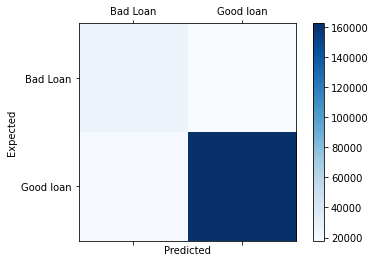

In [67]:
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
acc = round(accuracy_score(y_test, y_pred)*100, 2)
auc = round(roc_auc_score(y_test, y_pred)*100, 2)
print (f1, acc, auc)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
model_result = pd.DataFrame(columns=['Model','Accuracy','F1','AUC'])
model_result = model_result.append({'Model':'Decision Tree','Accuracy':acc,'F1':f1,"AUC":auc,\
                                             'Method':'Train test split'}, ignore_index=True)

In [85]:
# Decision Tree with balanced dataset
tree_para = {'max_depth':[10, 20, 30],'min_samples_leaf':[20, 50, 70]}
# dt2 = DecisionTreeClassifier()
grid = GridSearchCV(dt, tree_para, cv=10, scoring='accuracy')
grid.fit(x_train_balanced, y_train_balanced)
print("best parameters: " + str(grid.best_params_))
print("best estimator: " + str(grid.best_estimator_))
best_model=grid.best_estimator_
y_pred_balanced=best_model.predict(x_test_balanced)
f1 = round(f1_score(y_test_balanced, y_pred_balanced, average='weighted')*100, 2)
acc = round(accuracy_score(y_test_balanced, y_pred_balanced)*100, 2)
auc = round(roc_auc_score(y_test_balanced, y_pred_balanced)*100, 2)
print (f1, acc, auc)
print (confusion_matrix(y_test_balanced, y_pred_balanced))
model_result = model_result.append({'Model':'Decision Tree','Accuracy':acc,'F1':f1,"AUC":auc,\
                                             'Method':'Train test split with hyperparameter tuning'}, ignore_index=True)

best parameters: {'max_depth': 20, 'min_samples_leaf': 70}
best estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=70, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
82.02 82.02 82.03
[[36207  8461]
 [ 7525 36733]]


83.16 85.63 66.15


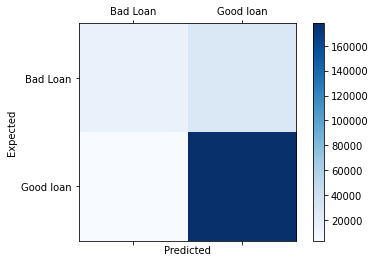

In [71]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
acc = round(accuracy_score(y_test, y_pred)*100, 2)
auc = round(roc_auc_score(y_test, y_pred)*100, 2)
print (f1, acc, auc)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
model_result = model_result.append({'Model':'Random Forest','Accuracy':acc,'F1':f1,'AUC':auc,\
                                    'Method':'Train test split'}, ignore_index=True)

In [86]:
# Random Forest with balanced dataset
tree_para = {'max_features':[50, 100, 150], 'n_estimators': [5, 10, 15], 'min_samples_leaf':[20, 50, 70]}
# rf = RandomForestClassifier()
grid = GridSearchCV(rf, tree_para, cv=10, scoring='accuracy')
grid.fit(x_train_balanced, y_train_balanced)
print("best parameters: " + str(grid.best_params_))
print("best estimator: " + str(grid.best_estimator_))
best_model=grid.best_estimator_
y_pred_balanced=best_model.predict(x_test_balanced)
f1 = round(f1_score(y_test_balanced, y_pred_balanced, average='weighted')*100, 2)
acc = round(accuracy_score(y_test_balanced, y_pred_balanced)*100, 2)
auc = round(roc_auc_score(y_test_balanced, y_pred_balanced)*100, 2)
print (f1, acc, auc)
print (confusion_matrix(y_test_balanced, y_pred_balanced))
model_result = model_result.append({'Model':'Random Forest','Accuracy':acc,'F1':f1,"AUC":auc,\
                                             'Method':'Train test split with hyperparameter tuning'}, ignore_index=True)

best parameters: {'max_features': 150, 'min_samples_leaf': 20, 'n_estimators': 15}
best estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=150,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
83.3 83.3 83.31
[[36587  8081]
 [ 6767 37491]]


83.96 86.1 67.7


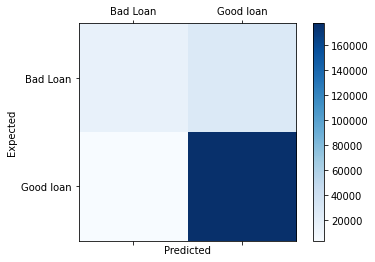

In [73]:
# Gradient Boosting Machine
gbm = GradientBoostingClassifier()
gbm.fit(x_train, y_train)
y_pred = gbm.predict(x_test)
f1 = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
acc = round(accuracy_score(y_test, y_pred)*100, 2)
auc = round(roc_auc_score(y_test, y_pred)*100, 2)
print (f1, acc, auc)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
model_result = model_result.append({'Model':'Gradient Boosting Machine','Accuracy':acc,'F1':f1,'AUC':auc,\
                                             'Method':'Train test split'}, ignore_index=True)

78.08 81.12 59.47


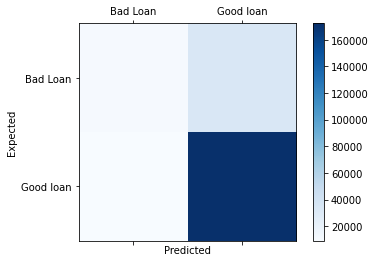

In [74]:
# SVM with linear SGD training
svm = linear_model.SGDClassifier(max_iter=10000)
svm.fit(x_train.astype(np.float64), y_train.astype(np.float64))
y_pred = svm.predict(x_test.astype(np.float64))
f1 = round(f1_score(y_test.astype(np.float64), y_pred, average='weighted')*100, 2)
acc = round(accuracy_score(y_test.astype(np.float64), y_pred)*100, 2)
auc = round(roc_auc_score(y_test.astype(np.float64), y_pred)*100, 2)
print (f1, acc, auc)
plot_confusion_matrix(confusion_matrix(y_test.astype(np.float64), y_pred))
model_result = model_result.append({'Model':'Linear SVM','Accuracy':acc,'F1':f1,'AUC':auc,\
                                             'Method':'Train test split'}, ignore_index=True)

77.17 81.26 57.4


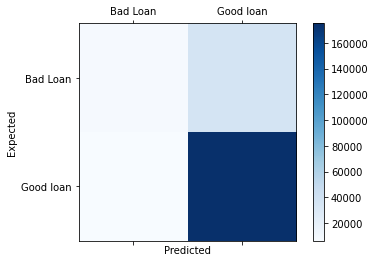

In [75]:
# Logistic Regression with linear SGD training
lr = linear_model.SGDClassifier(loss='log', max_iter=10000)
lr.fit(x_train.astype(np.float64), y_train.astype(np.float64))
y_pred = lr.predict(x_test.astype(np.float64))
f1 = round(f1_score(y_test.astype(np.float64), y_pred, average='weighted')*100, 2)
acc = round(accuracy_score(y_test.astype(np.float64), y_pred)*100, 2)
auc = round(roc_auc_score(y_test.astype(np.float64), y_pred)*100, 2)
print (f1, acc, auc)
plot_confusion_matrix(confusion_matrix(y_test.astype(np.float64), y_pred))
model_result = model_result.append({'Model':'Logistics Regression','Accuracy':acc,'F1':f1,"AUC":auc,\
                                             'Method':'Train test split'}, ignore_index=True)

## Deep Neural Networks

We can see that above common shallow learning models do not perform very well on this dataset. Next, we will try some deep learning models, for example: 
* Simple Neural Network with fully connected layers
* CNN with max pooling and fully connected layers

In [76]:
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)
print (y_train.value_counts())

# undersampling to balance the loan condition in the dataset --- Did not work well
# df_train = pd.merge(x_train, y_train, left_index=True, right_index=True)
# df_train_good = df_train[df_train['loan_condition']==1]
# df_train_bad = df_train[df_train['loan_condition']==0]
# df_train_good = df_train_good.sample(len(df_train_bad))
# print (df_train_good.shape)
# print (df_train_bad.shape)
# df_under = pd.concat([df_train_good, df_train_bad])
# print (df_under.shape)
# # split out the x & y labels
# x_train = df_under.drop(columns='loan_condition')
# y_train = df_under['loan_condition']

(677165, 169) (677165,)
(225421, 169) (225421,)
1    543403
0    133762
Name: loan_condition, dtype: int64


# Fit model on training data
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

541732/541732 [==============================] - 609s 1ms/step - loss: 0.5103 - accuracy: 0.8023 - val_loss: 0.5100 - val_accuracy: 0.8032
Epoch 2/10
541732/541732 [==============================] - 623s 1ms/step - loss: 0.5103 - accuracy: 0.8023 - val_loss: 0.5100 - val_accuracy: 0.8032
Epoch 3/10
541732/541732 [==============================] - 589s 1ms/step - loss: 0.5103 - accuracy: 0.8023 - val_loss: 0.5100 - val_accuracy: 0.8032
Epoch 4/10
541732/541732 [===

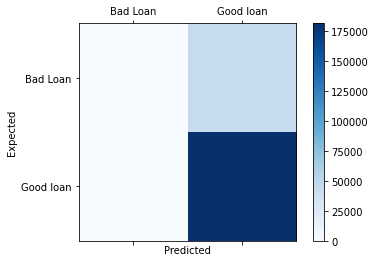

In [77]:
# Further split the training data into Train & val set
x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1) # val: 0.2 x 0.75 = 0.15

# Read the training data into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train2.values, y_train2.values))
# for element in dataset.as_numpy_iterator(): 
#     print(element)
#     break
train_dataset = train_dataset.shuffle(len(df)).batch(1)

# Simple Neural Network with Multiple fully connected layers
def simple_nn():
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

# # Assign higher class weight to 0 (bad loan) so as to prioritise correct classification of minority class
# class_weight = {0: 0.6, 1: 0.4}

# Early stopping if validaiton accuracy does not improve from the previous epoch
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

print('# Fit model on training data')
model = simple_nn()
model.fit(train_dataset, epochs=10, batch_size=128, validation_data=(x_val, y_val),callbacks=[callback])
model.summary()

print('\n# Evaluate on test data')
results = model.evaluate(x_test.values, y_test.values, batch_size=128)
print('test loss, test acc:', results)

print('\n# Generate predictions')
y_pred = model.predict(x_test.values).round()
f1 = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
acc = round(accuracy_score(y_test, y_pred)*100, 2)
auc = round(roc_auc_score(y_test, y_pred)*100, 2)
print (f1, acc, auc)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
model_result = model_result.append({'Model':'NN with FC Layer','Accuracy':acc,'F1':f1,"AUC":auc,\
                                             'Method':'Train test split'}, ignore_index=True)

During the training of our neural network, we add early stopping in case the validation accuracy does not improve after three more epochs. We can see that a simple Neural network with fully connected layers do not perform very well as the predictions tend to bias towards the majority class in the unbalanced dataset (i.e. always predicting good loan, which gives close to 80% accuracy. 

Next we try a simple __Convolutional Network Network__ with Max pooling. Along with it, we try to assign higher weightage to the minority class - 0, which indicates bad loan in this case. This gives more weight to the loss function, if a bad loan is predicted wrongly. 

Some of the techniques attempted:
- Different optimizers: __Adam__, Adagrad, RMSProp
- Different batch size: 32, __64__, 128
- Added __Batch Normalization__
- Added more layers
- Different activation units: __Relu, Sigmoid__, Softmax
- Higher classweights to the prediction of __Bad loans (0.6)__ than __Good loans (0.4)__
- __Early stopping__

# Fit model on training data
Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

541732/541732 [==============================] - 686s 1ms/step - loss: 0.4975 - accuracy: 0.8023 - val_loss: 0.4969 - val_accuracy: 0.8032
Epoch 2/10
541732/541732 [==============================] - 756s 1ms/step - loss: 0.4974 - accuracy: 0.8023 - val_loss: 0.4964 - val_accuracy: 0.8032
Epoch 3/10
541732/541732 [==============================] - 833s 2ms/step - loss: 0.4973 - accuracy: 0.8023 - val_loss: 0.4959 - val_accuracy: 0.8032
Epoch 4/10
541732/541732 [===

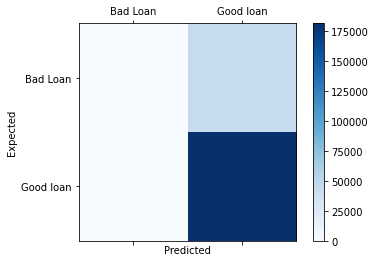

In [78]:
# Further split the training data into Train & val set
x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1) # val: 0.2 x 0.75 = 0.15

# Read the training data into tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train2.values.reshape(len(x_train2),13,13,1), y_train2.values))
# for element in dataset.as_numpy_iterator(): 
#     print(element)
#     break
train_dataset = train_dataset.shuffle(len(x_train)).batch(1)


# CNN with softmax activation
def cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(16, (2, 2), activation='relu', input_shape=(13, 13, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(32, (2, 2), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),
        tf.keras.layers.Dense(1),
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    model.compile(optimizer = optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

print('# Fit model on training data')
model = cnn()
# class_weight = {0: 0.6, 1: 0.4}
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(train_dataset, epochs=10, batch_size=64, validation_data=(x_val.values.reshape(len(x_val),13,13,1), y_val), callbacks=[callback])
      # , class_weight=class_weight)
model.summary()

print('\n# Evaluate on test data')
results = model.evaluate(x_test.values.reshape(len(x_test),13,13,1), y_test.values, batch_size=64)
print('test loss, test acc:', results)

print('\n# Generate predictions')
y_pred = model.predict(x_test.values.reshape(len(x_test),13,13,1)).round()
f1 = round(f1_score(y_test, y_pred, average='weighted')*100, 2)
acc = round(accuracy_score(y_test, y_pred)*100, 2)
auc = round(roc_auc_score(y_test, y_pred)*100, 2)
print (f1, acc, auc)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
model_result = model_result.append({'Model':'CNN','Accuracy':acc,'F1':f1,"AUC":auc,\
                                             'Method':'Train test split'}, ignore_index=True)

Plot the accuracy, f1, auc for these models attempted: Decision Tree, Random Forest, Gradient Boosting Machine

Text(0.5, 1.0, 'AUC for each model')

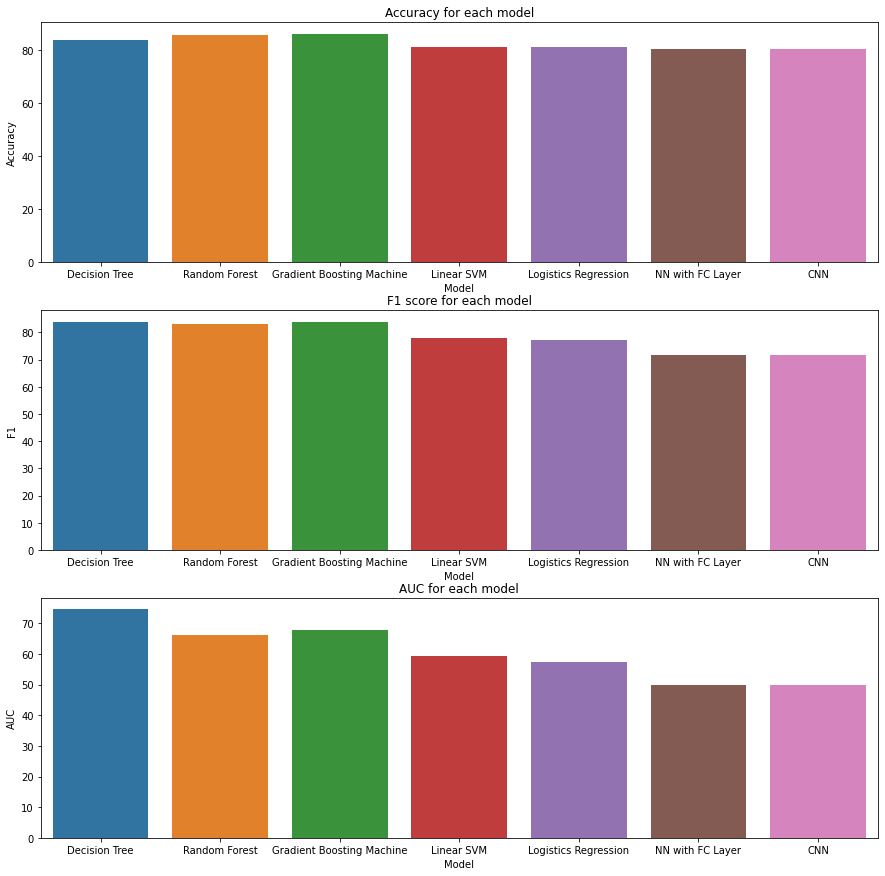

In [79]:
f, ax = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=model_result, x='Model', y='Accuracy',ax=ax[0])
sns.barplot(data=model_result, x='Model', y='F1',ax=ax[1])
sns.barplot(data=model_result, x='Model', y='AUC',ax=ax[2])
ax[0].set_title('Accuracy for each model')
ax[1].set_title('F1 score for each model')
ax[2].set_title('AUC for each model')

We can inspect the top 500 important features for the Decision Tree model. 

In [80]:
pd.set_option('display.float_format', lambda x: '%.10f' % x)
dict = zip(dt.feature_importances_, x_train.columns)
ls = (sorted(dict)[-500:])
useful_features = set()
for i in ls:
    useful_features.add(i[1])
print (useful_features)

{'disbursement_method', 'addr_state_NY', 'home_ownership_RENT', 'term', 'addr_state_OR', 'sub_grade_F1', 'purpose_house', 'num_tl_120dpd_2m', 'addr_state_NV', 'addr_state_MN', 'purpose_wedding', 'acc_open_past_24mths', 'purpose_debt_consolidation', 'delinq_amnt', 'addr_state_VT', 'sub_grade_E3', 'sub_grade_F5', 'addr_state_AL', 'purpose_renewable_energy', 'addr_state_TN', 'sub_grade_A1', 'sub_grade_B5', 'chargeoff_within_12_mths', 'sub_grade_B3', 'delinq_2yrs', 'grade_A', 'bc_util', 'addr_state_DC', 'addr_state_AK', 'sub_grade_B1', 'sub_grade_D1', 'emp_length_9 years', 'addr_state_ND', 'application_type', 'sub_grade_A2', 'issue_d', 'num_actv_bc_tl', 'sub_grade_D5', 'num_actv_rev_tl', 'pct_tl_nvr_dlq', 'sub_grade_G4', 'sub_grade_F2', 'addr_state_ID', 'addr_state_VA', 'addr_state_IN', 'total_il_high_credit_limit', 'region_SouthEast', 'region_NorthEast', 'int_rate', 'tax_liens', 'emp_length_2 years', 'mort_acc', 'purpose_medical', 'addr_state_MI', 'sub_grade_B4', 'emp_length_3 years', 'ad

## Cross Validation approach
Also, we attempted to use Cross validation approach, instead of train-test split. We have below findings:
- However, there is no significant increase in accuracy
- There is some increase in F1 score & AUC score. 
- Hence, we can concludet that cross validation approach are more robust than train test split for prediction of imbalanced dataset.

In [81]:
# Using Cross Validation approach
X = pd.concat([x_train, x_test])
y = pd.concat([y_train, y_test])

dt_pipeline = make_pipeline(SimpleImputer(),DecisionTreeClassifier())
dt_scores = cross_validate(dt_pipeline, X, y, scoring=['accuracy','f1','roc_auc'])
print ("Metrics for Decision Tree Classifier")
print(dt_scores)

rf_pipeline = make_pipeline(SimpleImputer(), RandomForestClassifier())
rf_scores = cross_validate(rf_pipeline, X, y, scoring=['accuracy','f1','roc_auc'])
print ("Metrics for Random Forest Classifier")
print(rf_scores)

gbm_pipeline = make_pipeline(SimpleImputer(), GradientBoostingClassifier())
gbm_scores = cross_validate(gbm_pipeline, X, y, scoring=['accuracy','f1','roc_auc'])
print ("Metrics for Gradient Boosting Machine")
print(gbm_scores)

svm_pipeline = make_pipeline(SimpleImputer(), linear_model.SGDClassifier())
svm_scores = cross_validate(svm_pipeline, X, y, scoring=['accuracy','f1','roc_auc'])
print ("Metrics for Linear SVM")
print(svm_scores)

lr_pipeline = make_pipeline(SimpleImputer(), linear_model.SGDClassifier(loss='log'))
lr_scores = cross_validate(lr_pipeline, X, y, scoring=['accuracy','f1','roc_auc'])
print ("Metrics for Logistic Regression with linear SGD")
print(lr_scores)

Metrics for Decision Tree Classifier
{'fit_time': array([56.49392104, 53.20633984, 53.89004016, 53.70691991, 55.33336806]), 'score_time': array([1.35123992, 1.24411297, 1.24763203, 1.27606201, 1.32701969]), 'test_accuracy': array([0.83640413, 0.83394362, 0.83646416, 0.83558889, 0.83502939]), 'test_f1': array([0.89781032, 0.8961942 , 0.8978869 , 0.89722448, 0.89701203]), 'test_roc_auc': array([0.74629112, 0.74357646, 0.74580365, 0.74614963, 0.74321843])}
Metrics for Random Forest Classifier
{'fit_time': array([420.35040903, 416.20546794, 394.91378474, 380.0458529 ,
       377.98449183]), 'score_time': array([22.803087  , 22.32671809, 20.54071617, 20.75816202, 20.15016818]), 'test_accuracy': array([0.85555457, 0.85541528, 0.85676141, 0.85547068, 0.85564794]), 'test_f1': array([0.91603688, 0.91601236, 0.91664222, 0.91598181, 0.91611296]), 'test_roc_auc': array([0.86000139, 0.86050371, 0.86572078, 0.86140264, 0.8611892 ])}
Metrics for Gradient Boosting Machine
{'fit_time': array([490.61068

/Users/chihongtao/anaconda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/chihongtao/anaconda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Metrics for Linear SVM
{'fit_time': array([427.69477415, 393.81579995, 451.87407303, 448.54980707,
       451.58056784]), 'score_time': array([1.02550793, 1.0055542 , 0.96641016, 0.97255993, 0.99922919]), 'test_accuracy': array([0.81416812, 0.81254951, 0.81185152, 0.23412199, 0.80513193]), 'test_f1': array([0.89514122, 0.89506881, 0.89313179, 0.09090072, 0.88799524]), 'test_roc_auc': array([0.7036969 , 0.68384821, 0.69692123, 0.67935139, 0.65494197])}


/Users/chihongtao/anaconda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/Users/chihongtao/anaconda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:554: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Metrics for Logistic Regression with linear SGD
{'fit_time': array([456.19018412, 460.27314401, 459.88347387, 349.59832716,
       339.0897491 ]), 'score_time': array([0.96925616, 0.94493079, 0.97927094, 0.99857092, 1.23249197]), 'test_accuracy': array([0.79908929, 0.80977969, 0.81201217, 0.29269819, 0.62728164]), 'test_f1': array([0.88421066, 0.89176769, 0.89515459, 0.22432019, 0.73001019]), 'test_roc_auc': array([0.63258525, 0.66383008, 0.64571823, 0.66104198, 0.66734062])}


In [87]:
# Write the Cross Validation result into the dataframe for plotting
model_result = model_result.append({'Model':'Decision Tree','Accuracy':dt_scores['test_accuracy'].mean()*100,\
                                    'F1':dt_scores['test_f1'].mean()*100,
                                    "AUC":dt_scores['test_roc_auc'].mean()*100,'Method':'Cross validation'}, ignore_index=True)
model_result = model_result.append({'Model':'Random Forest','Accuracy':rf_scores['test_accuracy'].mean()*100,'F1':rf_scores['test_f1'].mean()*100,
                                    "AUC":rf_scores['test_roc_auc'].mean()*100,'Method':'Cross validation'}, ignore_index=True)

model_result = model_result.append({'Model':'Gradient Boosting Machine','Accuracy':gbm_scores['test_accuracy'].mean()*100,'F1':gbm_scores['test_f1'].mean()*100,
                                    "AUC":gbm_scores['test_roc_auc'].mean()*100,'Method':'Cross validation'}, ignore_index=True)

model_result = model_result.append({'Model':'Linear SVM','Accuracy':svm_scores['test_accuracy'].mean()*100,'F1':svm_scores['test_f1'].mean()*100,
                                    "AUC":svm_scores['test_roc_auc'].mean()*100,'Method':'Cross validation'}, ignore_index=True)

model_result = model_result.append({'Model':'Logistics Regression','Accuracy':lr_scores['test_accuracy'].mean()*100,'F1':lr_scores['test_f1'].mean()*100,
                                    "AUC":lr_scores['test_roc_auc'].mean()*100,'Method':'Cross validation'}, ignore_index=True)

Text(0.5, 1.0, 'AUC for each model')

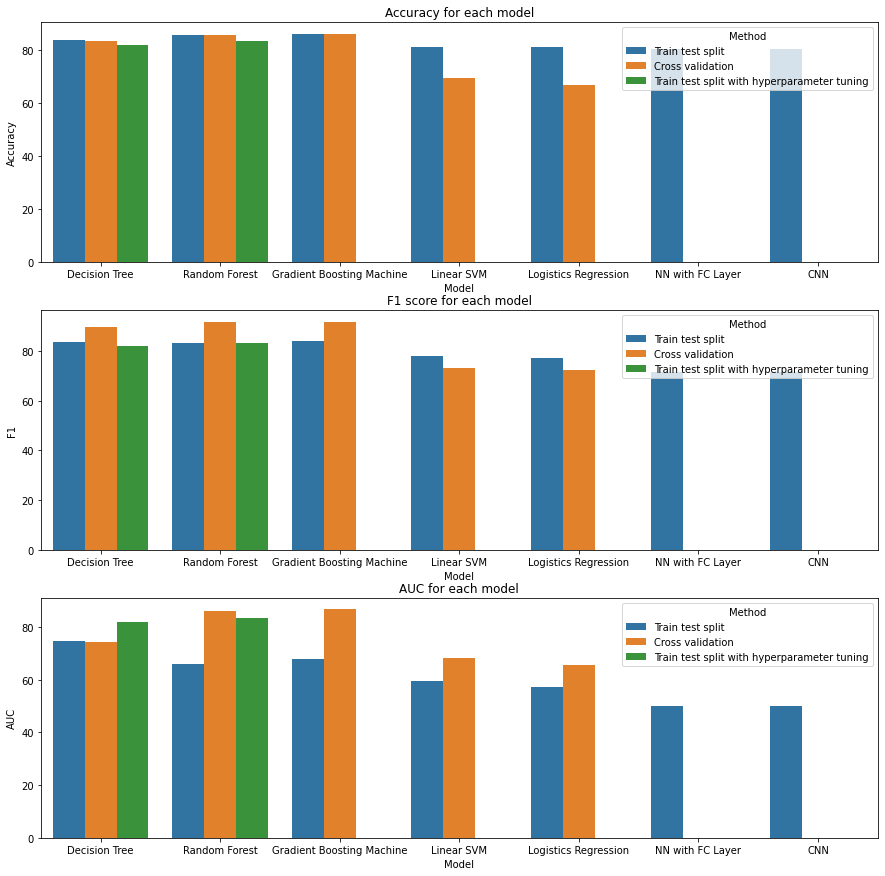

In [88]:
# print (model_result)
model_order = ['Decision Tree','Random Forest','Gradient Boosting Machine','Linear SVM','Logistics Regression','NN with FC Layer','CNN']

# Plot the result comparing Train_test split with Cross validation approach 
f, ax = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=model_result, x='Model', y='Accuracy',ax=ax[0], hue='Method', order=model_order)
sns.barplot(data=model_result, x='Model', y='F1',ax=ax[1], hue='Method', order=model_order)
sns.barplot(data=model_result, x='Model', y='AUC',ax=ax[2], hue='Method', order=model_order)
ax[0].set_title('Accuracy for each model')
ax[1].set_title('F1 score for each model')
ax[2].set_title('AUC for each model')